In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, Subset
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib
from sklearn.base import clone


In [2]:
#Canonical_SMILES

In [3]:


# 读取数据
data = pd.read_csv("./imputed_selected_features_Flam.csv")
data = data.dropna()  # 删除缺失值
smiles_data = data['SMILES'].tolist()



In [4]:
labels=data['Flammability'].tolist()

In [5]:
# 数据增强函数：简单的 SMILES 序列翻转
def augment_smiles(smiles):
    """简单的数据增强方法，例如旋转 SMILES 字符串"""
    if random.random() > 0.5:
        return smiles[::-1]  # 翻转字符串
    return smiles


class SMILES_Dataset(torch.utils.data.Dataset):
    def __init__(self, smiles_list, class_labels, tokenizer):
        self.smiles = smiles_list
        self.class_labels = class_labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        class_label = self.class_labels[idx]
        tokens = self.tokenizer(smiles, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return tokens, torch.tensor(class_label, dtype=torch.long)




class ChemBERTa_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ChemBERTa_Classifier, self).__init__()
        # 加载预训练的ChemBERTa模型
        self.chemberta = chemberta_model  # 假设chemberta_model已定义
        hidden_size = self.chemberta.config.hidden_size  # 一般为768

        # 分类任务的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, tokens):
        output = self.chemberta(**tokens)
        cls_embedding = output.last_hidden_state[:, 0, :]  # [CLS] token 嵌入
        class_output = self.classifier(cls_embedding)  # 分类任务输出
        return class_output

In [6]:
import selfies as sf
from transformers import PreTrainedTokenizer
import torch

class SelfiesTokenizer(PreTrainedTokenizer):
    def __init__(self, vocab=None, **kwargs):
        if vocab is None:
            vocab = []
        self.vocab = vocab
        self.vocab_dict = {word: idx for idx, word in enumerate(self.vocab)}
        self.inv_vocab_dict = {idx: word for word, idx in self.vocab_dict.items()}
        super().__init__(**kwargs)
        # 设置特殊 token，注意这些值必须在词表中
        self._pad_token = "[PAD]" if "[PAD]" in self.vocab_dict else None
        self._cls_token = "[CLS]" if "[CLS]" in self.vocab_dict else None
        self._sep_token = "[SEP]" if "[SEP]" in self.vocab_dict else None
        self._unk_token = "[UNK]" if "[UNK]" in self.vocab_dict else None
        self._mask_token = "[MASK]" if "[MASK]" in self.vocab_dict else None

    @property
    def pad_token(self):
        return self._pad_token

    @pad_token.setter
    def pad_token(self, value):
        self._pad_token = value

    @property
    def pad_token_id(self):
        if self._pad_token is None:
            return None
        return self.vocab_dict.get(self._pad_token, None)

    def get_vocab(self):
        return self.vocab_dict

    @property
    def vocab_size(self):
        return len(self.vocab_dict)

    def add_special_tokens(self, special_tokens_dict):
        added = 0
        for token_name, token_str in special_tokens_dict.items():
            if token_str not in self.vocab_dict:
                idx = len(self.vocab_dict)
                self.vocab_dict[token_str] = idx
                self.inv_vocab_dict[idx] = token_str
                added += 1
            if token_name == "pad_token":
                self._pad_token = token_str
            elif token_name == "cls_token":
                self._cls_token = token_str
            elif token_name == "sep_token":
                self._sep_token = token_str
            elif token_name == "unk_token":
                self._unk_token = token_str
            elif token_name == "mask_token":
                self._mask_token = token_str
        return added

    def _tokenize(self, text):
        """内部分词逻辑：将 SMILES 转换为 SELFIES，然后拆分为 token 列表"""
        selfies_str = sf.encoder(text)
        tokens = list(sf.split_selfies(selfies_str))
        return tokens

    def tokenize(self, text, **kwargs):
        # 兼容 transformers 可能传入的额外参数
        return self._tokenize(text)

    def _convert_token_to_id(self, token):
        return self.vocab_dict.get(token, self.vocab_dict.get("[UNK]", 0))

    def _convert_id_to_token(self, index):
        return self.inv_vocab_dict.get(index, "[UNK]")

    def convert_tokens_to_ids(self, tokens):
        return [self._convert_token_to_id(token) for token in tokens]

    def convert_ids_to_tokens(self, ids):
        return [self._convert_id_to_token(idx) for idx in ids]

    def encode(self, text, add_special_tokens=True):
        tokens = self.tokenize(text)
        token_ids = self.convert_tokens_to_ids(tokens)
        if add_special_tokens:
            if self._cls_token is not None:
                token_ids = [self._convert_token_to_id(self._cls_token)] + token_ids
            if self._sep_token is not None:
                token_ids.append(self._convert_token_to_id(self._sep_token))
        return torch.tensor(token_ids, dtype=torch.long)

    def decode(self, token_ids):
        tokens = self.convert_ids_to_tokens(token_ids)
        return "".join(tokens)

    def __call__(self, text, padding='max_length', truncation=True, max_length=128, return_tensors='pt'):
        # 调用 encode 得到 token_ids
        token_ids = self.encode(text, add_special_tokens=True).tolist()
        # 处理 truncation/padding
        if truncation and len(token_ids) > max_length:
            token_ids = token_ids[:max_length]
        if padding == "max_length":
            token_ids = token_ids + [self.pad_token_id] * (max_length - len(token_ids))
        attention_mask = [1 if tid != self.pad_token_id else 0 for tid in token_ids]
        if return_tensors == "pt":
            return {
                "input_ids": torch.tensor([token_ids], dtype=torch.long),
                "attention_mask": torch.tensor([attention_mask], dtype=torch.long)
            }
        else:
            return {"input_ids": token_ids, "attention_mask": attention_mask}

# --- 测试自定义 Tokenizer ---
import selfies as sf
base_vocab = ["[CLS]", "[SEP]", "[PAD]", "[MASK]", "[UNK]"] + list(sf.get_semantic_robust_alphabet())
tokenizer = SelfiesTokenizer(base_vocab)
tokenizer.add_special_tokens({
    "pad_token": "[PAD]",
    "unk_token": "[UNK]",
    "cls_token": "[CLS]",
    "sep_token": "[SEP]",
    "mask_token": "[MASK]"
})

# 测试 __call__
smiles_example = "CC(Cl)Br"
encoding = tokenizer(smiles_example, padding='max_length', truncation=True, max_length=10, return_tensors="pt")
print("Encoding result:", encoding)


# # **1. 定义 SELFIES 词表**
# selfies_vocab = ["[CLS]", "[SEP]", "[PAD]", "[MASK]", "[UNK]"] + list(sf.get_semantic_robust_alphabet())

# # **2. 创建 SELFIES Tokenizer**
# selfies_tokenizer = SelfiesTokenizer(selfies_vocab)

# # **3. 测试 SELFIES Tokenizer**
# smiles_example = "O=[N+]([O-])OCC(CO[N+](=O)[O-])O[N+](=O)[O-]"
# tokens = selfies_tokenizer.tokenize(smiles_example)
# print("SELFIES Tokenized:", tokens)

# # **4. 将 SELFIES Token 转换为 ID**
# token_ids = selfies_tokenizer.encode(smiles_example)
# print("Token IDs:", token_ids)

# # **5. 解码回 SELFIES**
# decoded_selfies = selfies_tokenizer.decode(token_ids.tolist())
# print("Decoded SELFIES:", decoded_selfies)



Encoding result: {'input_ids': tensor([[ 0, 14, 14,  9, 14, 32, 61,  1,  2,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])}


In [7]:
# import selfies as sf

# def tokenize_smiles_selfies(smiles):
#     """
#     1. 将 SMILES 转换为 SELFIES 形式（确保结构信息不丢失）
#     2. 使用 SELFIES 解析正确的分词（包括 Cl, Br）
#     """
#     selfies_str = sf.encoder(smiles)  # SMILES → SELFIES
#     tokens = list(sf.split_selfies(selfies_str))  # 分词
#     return tokens

# # 示例 SMILES
# smiles_example = "O=[N+]([O-])OCC(CO[N+](=O)[O-])O[N+](=O)[O-]"
# tokens = tokenize_smiles_selfies(smiles_example)
# print("SELFIES Tokenized SMILES:", tokens)

In [8]:
# from transformers import RobertaModel

# # 加载 ChemBERTa（但替换 tokenizer）
# chemberta_model = RobertaModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# # 处理输入
# smiles = "O=[N+]([O-])OCC(CO[N+](=O)[O-])O[N+](=O)[O-]"
# input_ids = selfies_tokenizer.encode(smiles).unsqueeze(0)  # 添加 batch 维度

# # 送入 Transformer
# output = chemberta_model(input_ids=input_ids)
# print(output.last_hidden_state.shape)  # 输出 Transformer 结果


In [9]:
# 加载 ChemBERTa 模型和 tokenizer
model_name = "../ChemBERTa"
#tokenizer = RobertaTokenizer.from_pretrained(model_name)

#tokenizer = SelfiesTokenizer(base_vocab)
chemberta_model = RobertaModel.from_pretrained(model_name)

In [10]:
import selfies as sf
base_vocab = ["[CLS]", "[SEP]", "[PAD]", "[MASK]", "[UNK]"] + list(sf.get_semantic_robust_alphabet())
tokenizer_instance = SelfiesTokenizer(base_vocab)
tokenizer_instance.add_special_tokens({
    "pad_token": "[PAD]",
    "unk_token": "[UNK]",
    "cls_token": "[CLS]",
    "sep_token": "[SEP]",
    "mask_token": "[MASK]"
})
dataset = SMILES_Dataset(smiles_data, labels, tokenizer_instance)

In [11]:
from torch.utils.data import DataLoader, random_split
import torch



# 加载数据集
#dataset = SMILES_Dataset(smiles_data, labels,tokenizer)  # 只传入SMILES和分类标签

# 数据集划分：80%训练集，20%验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, drop_last=True)


In [12]:
# 假设 num_classes 已经定义，表示分类任务的类别数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 使用类别数来初始化分类器模型
model = ChemBERTa_Classifier(num_classes=2).to(device) 

In [13]:
# 加载最佳模型
model.load_state_dict(torch.load('./best_chemberta_model.pth'))

<All keys matched successfully>

In [14]:
import numpy as np
import torch
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt

def compute_self_attention_weights(smiles, model, tokenizer, device, max_length=128):
    encoding = tokenizer(smiles, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    encoding = {key: val.to(device) for key, val in encoding.items()}
    
    outputs = model.chemberta(**encoding, output_attentions=True)
    attentions = outputs.attentions[-1]  # 取最后一层注意力
    avg_attention = attentions.mean(dim=1)
    cls_attention = avg_attention[0, 0, :]  # [CLS] 对所有 token 的注意力
    
    # **打印实际 Token 数量**
    #print(f"Input IDs Shape: {encoding['input_ids'].shape}")
    #print(f"Attention Weights Shape: {cls_attention.shape}")
    
    # **去除特殊 token**
    valid_tokens = [t for t in tokenizer.tokenize(smiles) if t not in ["[CLS]", "[SEP]", "[PAD]"]]
    token_weights = cls_attention[1:len(valid_tokens) + 1].cpu().detach().numpy()
    
    return valid_tokens, token_weights

def visualize_attention(smiles, tokens, weights, highlight_percent=20, image_size=(300,300)):
    """
    绘制分子结构，并将自注意力权重最高的 highlight_percent% 原子标记为红色。
    
    参数：
        smiles: SMILES 字符串
        tokens: SELFIES 分词结果列表（不包含特殊 token）
        weights: 对应每个 token 的注意力权重（numpy 数组）
        highlight_percent: 要高亮的比例（例如 20 表示高亮权重最高 20% 的原子）
        image_size: 绘图大小
    """
    # 解析 SMILES 得到 RDKit 分子对象
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("无法解析 SMILES:", smiles)
        return
    
    num_atoms = mol.GetNumAtoms()
    if len(tokens) != num_atoms:
        print("警告：SELFIES tokens 数量（{}）与 RDKit 原子数（{}）不匹配！".format(len(tokens), num_atoms))
        # 取二者最小值进行映射
        n = min(len(tokens), num_atoms)
    else:
        n = num_atoms

    # 计算权重阈值：选取最高的 highlight_percent% 权重
    threshold = np.percentile(weights, 100 - highlight_percent)
    # 找到权重高于阈值的 token 对应的原子索引（假设顺序一致）
    highlight_atoms = [i for i, w in enumerate(weights[:n]) if w >= threshold]
    
    # 定义高亮颜色：红色
    highlight_colors = {atom_idx: (1.0, 0.0, 0.0) for atom_idx in highlight_atoms}
    
    # 使用 RDKit 绘图
    drawer = rdMolDraw2D.MolDraw2DCairo(image_size[0], image_size[1])
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    png_data = drawer.GetDrawingText()
    
    # 保存并显示图片
    with open("molecule_attention.png", "wb") as f:
        f.write(png_data)
    
    img = plt.imread("molecule_attention.png")
    plt.figure(figsize=(4,4),dpi=500)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# === 示例调用 ===
# 假设你已经实例化了模型和 tokenizer，并将它们移动到合适设备上
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ChemBERTa_Classifier(num_classes=2).to(device)
# tokenizer_instance = <你的 SelfiesTokenizer 实例>



In [17]:
smiles_example = "CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC"  # 示例 SMILES
tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
print("SELFIES Tokens:", tokens)
print("Attention Weights:", weights)

#visualize_attention(smiles_example, tokens, weights, highlight_percent=0)

SELFIES Tokens: ['[C]', '[C]', '[C]', '[C]', '[C]', '[Branch1]', '[Ring1]', '[C]', '[C]', '[C]', '[O]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[C]', '[=Branch1]', '[C]', '[=O]', '[O]', '[C]', '[C]', '[Branch1]', '[Ring1]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]']
Attention Weights: [0.01921569 0.01968474 0.02832039 0.03531823 0.02088672 0.02416203
 0.02724398 0.02712864 0.02609945 0.02205858 0.01970723 0.02945036
 0.03407155 0.023822   0.01815037 0.01373899 0.02327422 0.01621207
 0.02425773 0.0281619  0.03934131 0.02609355 0.05566686 0.04590772
 0.04607865 0.02967355 0.03113948 0.02005815 0.01881947 0.01807289
 0.01781597 0.0179464  0.01581225 0.01722261 0.01749133 0.01731584
 0.01814875 0.02099066]


In [18]:
smiles_example = "CCCCC(CC)COP(=O)(O)OCC(CC)CCCC"  # 示例 SMILES
tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
print("SELFIES Tokens:", tokens)
print("Attention Weights:", weights)

#visualize_attention(smiles_example, tokens, weights, highlight_percent=0)

SELFIES Tokens: ['[C]', '[C]', '[C]', '[C]', '[C]', '[Branch1]', '[Ring1]', '[C]', '[C]', '[C]', '[O]', '[P]', '[=Branch1]', '[C]', '[=O]', '[Branch1]', '[C]', '[O]', '[O]', '[C]', '[C]', '[Branch1]', '[Ring1]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]']
Attention Weights: [0.01925772 0.01929227 0.02523798 0.02915809 0.02033894 0.02308711
 0.0261717  0.02715802 0.0200409  0.02545133 0.02173117 0.02203674
 0.06111187 0.03726647 0.05629683 0.0478657  0.04062113 0.03975731
 0.0379319  0.03703221 0.03830601 0.03953961 0.04032047 0.03503966
 0.03161648 0.03427999 0.03174395 0.03329945 0.03066698]


In [19]:
smiles_example = "CN(C)C(=O)NC1=CC(=C(C=C1)Cl)Cl"  # 示例 SMILES
tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
print("SELFIES Tokens:", tokens)
print("Attention Weights:", weights)

#visualize_attention(smiles_example, tokens, weights, highlight_percent=0)

SELFIES Tokens: ['[C]', '[N]', '[Branch1]', '[C]', '[C]', '[C]', '[=Branch1]', '[C]', '[=O]', '[N]', '[C]', '[=C]', '[C]', '[=Branch1]', '[=Branch2]', '[=C]', '[Branch1]', '[Branch1]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[Cl]', '[Cl]']
Attention Weights: [0.04755688 0.04303492 0.03905111 0.06342124 0.0159264  0.01909477
 0.03451517 0.01326723 0.03344319 0.02125333 0.01832724 0.07933017
 0.01370759 0.04575239 0.02547954 0.04080134 0.05610128 0.034763
 0.0406424  0.06493849 0.04780353 0.06347978 0.04495088 0.04537556]


In [20]:
smiles_example = "CCOP(=S)(C1=CC=CC=C1)OC2=CC=C(C=C2)[N+](=O)[O-]"  # 示例 SMILES
tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
print("SELFIES Tokens:", tokens)
print("Attention Weights:", weights)

#visualize_attention(smiles_example, tokens, weights, highlight_percent=0)

SELFIES Tokens: ['[C]', '[C]', '[O]', '[P]', '[=Branch1]', '[C]', '[=S]', '[Branch1]', '[=Branch2]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[O]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[Branch1]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[N+1]', '[=Branch1]', '[C]', '[=O]', '[O-1]']
Attention Weights: [0.02493179 0.02746525 0.02859185 0.02956459 0.03442444 0.0324889
 0.01854259 0.01347199 0.02361796 0.0174375  0.03333974 0.02175175
 0.04694567 0.02784315 0.05216147 0.03501932 0.07622969 0.0250128
 0.0394331  0.03324194 0.0283117  0.04178871 0.0292507  0.02653061
 0.02711459 0.03348861 0.02074324 0.02776359 0.02240236 0.02580864
 0.01002756 0.01628208 0.00969815]


In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# from io import BytesIO
# from PIL import Image
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import rdMolDraw2D

# def visualize_attention(smiles, atom_weights, save_path=None):
#     """
#     绘制分子结构，并用颜色显示每个原子的注意力权重。
    
#     参数:
#         smiles (str): 分子的 SMILES 结构
#         atom_weights (list): 每个原子的注意力权重（应与分子中的原子数量一致）
#         save_path (str, optional): 如果提供，则保存图像
#     """
#     # 解析 SMILES 并检查原子数量
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         raise ValueError("无效的 SMILES 结构")
#     num_atoms = mol.GetNumAtoms()
    
#     if len(atom_weights) != num_atoms:
#         raise ValueError(f"注意力权重数量 ({len(atom_weights)}) 与原子数量 ({num_atoms}) 不匹配")

#     # 归一化权重（0~1之间）
#     norm_weights = np.array(atom_weights)
#     norm_weights = (norm_weights - norm_weights.min()) / (norm_weights.max() - norm_weights.min() + 1e-6)

#     # 定义颜色映射（红色高，灰色低）
#     atom_colors = {i: (1, 1-norm_weights[i], 1-norm_weights[i]) for i in range(num_atoms)}

#     # RDKit 可视化
#     drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)  # 500x500 分辨率
#     drawer.drawOptions().atomHighlightsAreCircles = True
#     drawer.drawOptions().highlightColor = (1.0, 0.5, 0.5)

#     # 高亮原子
#     atom_radii = {i: 0.3 + norm_weights[i] * 0.3 for i in range(num_atoms)}  # 半径随权重变化
#     Chem.rdDepictor.Compute2DCoords(mol)
#     drawer.DrawMolecule(mol, highlightAtoms=list(atom_colors.keys()), highlightAtomColors=atom_colors, highlightAtomRadii=atom_radii)
#     drawer.FinishDrawing()
    
#     # 获取 RDKit 生成的二进制图像数据
#     img_bytes = drawer.GetDrawingText()

#     # 用 PIL 读取二进制图像数据
#     img = Image.open(BytesIO(img_bytes))

#     # 显示或保存图像
#     if save_path:
#         img.save(save_path)
#     else:
#         plt.figure(figsize=(5, 5))
#         plt.imshow(img)
#         plt.axis("off")
#         plt.show()


# # ✅ 示例使用
# smiles_example = "CC(=O)Oc1ccccc1C(=O)O"
# attention_weights = [0.1, 0.3, 0.8, 0.6, 0.2, 0.7, 0.5, 0.3, 0.9, 0.4, 0.2, 0.1,0.2]  # 假设的注意力权重
# visualize_attention(smiles_example, attention_weights)


In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import rdMolDraw2D
# from io import BytesIO
# from PIL import Image

# def visualize_molecule_with_heatmap(smiles, atom_weights, save_path=None):
#     """
#     绘制分子 2D 结构，并在上方显示注意力权重的热力图。
    
#     参数:
#         smiles (str): 分子的 SMILES 结构
#         atom_weights (list): 每个原子的注意力权重（长度应与 SMILES 中的原子数一致）
#         save_path (str, optional): 如果提供，将保存图片
#     """
#     # 解析 SMILES 结构
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         raise ValueError("无效的 SMILES 结构")
    
#     num_atoms = mol.GetNumAtoms()
    
#     if len(atom_weights) != num_atoms:
#         raise ValueError(f"注意力权重数量 ({len(atom_weights)}) 与原子数量 ({num_atoms}) 不匹配")

#     # 归一化权重（0~1之间）
#     norm_weights = np.array(atom_weights)
#     norm_weights = (norm_weights - norm_weights.min()) / (norm_weights.max() - norm_weights.min() + 1e-6)

#     # 创建热力图数据
#     atom_indices = np.arange(num_atoms).reshape(1, -1)  # 1 行 N 列
#     weight_matrix = np.array(norm_weights).reshape(1, -1)  # 1 行 N 列

#     # 设置颜色映射（红色高，灰色低）
#     atom_colors = {i: (1, 1-norm_weights[i], 1-norm_weights[i]) for i in range(num_atoms)}

#     # 画布布局
#     fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 3]})

#     # (1) 绘制热力图
#     sns.heatmap(weight_matrix, annot=True, cmap="Reds", cbar=False, xticklabels=atom_indices.flatten(), yticklabels=["Weight"], ax=axes[0])
#     axes[0].set_xticklabels(axes[0].get_xticks(), rotation=0)  # 让 X 轴刻度水平
#     axes[0].set_yticklabels(["Weight"], rotation=0)  # Y 轴保持水平
#     axes[0].set_xlabel("原子编号")
    
#     # (2) RDKit 可视化
#     drawer = rdMolDraw2D.MolDraw2DCairo(500, 300)
#     drawer.drawOptions().atomHighlightsAreCircles = True
#     drawer.drawOptions().highlightColor = (1.0, 0.5, 0.5)

#     atom_radii = {i: 0.5 + norm_weights[i] * 0.5 for i in range(num_atoms)}
#     Chem.rdDepictor.Compute2DCoords(mol)
#     drawer.DrawMolecule(mol, highlightAtoms=list(atom_colors.keys()), highlightAtomColors=atom_colors, highlightAtomRadii=atom_radii)
#     drawer.FinishDrawing()
    
#     # 读取 RDKit 生成的图像
#     img_bytes = drawer.GetDrawingText()
#     img = Image.open(BytesIO(img_bytes))
    
#     # 在 Matplotlib 画布上绘制 RDKit 图像
#     axes[1].imshow(img)
#     axes[1].axis("off")

#     # 显示或保存
#     if save_path:
#         plt.savefig(save_path, bbox_inches='tight', dpi=300)
#     else:
#         plt.show()

# # ✅ 示例使用
# smiles_example = "CC(=O)Oc1ccccc1C(=O)O"
# tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
# visualize_molecule_with_heatmap(smiles_example, weights)


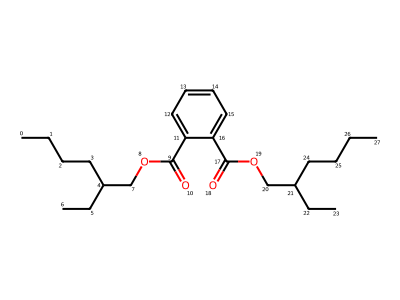

In [23]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor

# 你的SMILES字符串
smiles = "CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC"  # 示例，替换为你的SMILES

# 生成分子对象
mol = Chem.MolFromSmiles(smiles)
rdDepictor.Compute2DCoords(mol)  # 计算二维坐标

# 给每个原子编号
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("atomNote", str(i))  # 设置原子标签

# 绘制分子结构
img = Draw.MolToImage(mol, size=(400, 300))

img.show()
Draw.MolToFile(mol, "molecule.png", size=(2000, 1600))

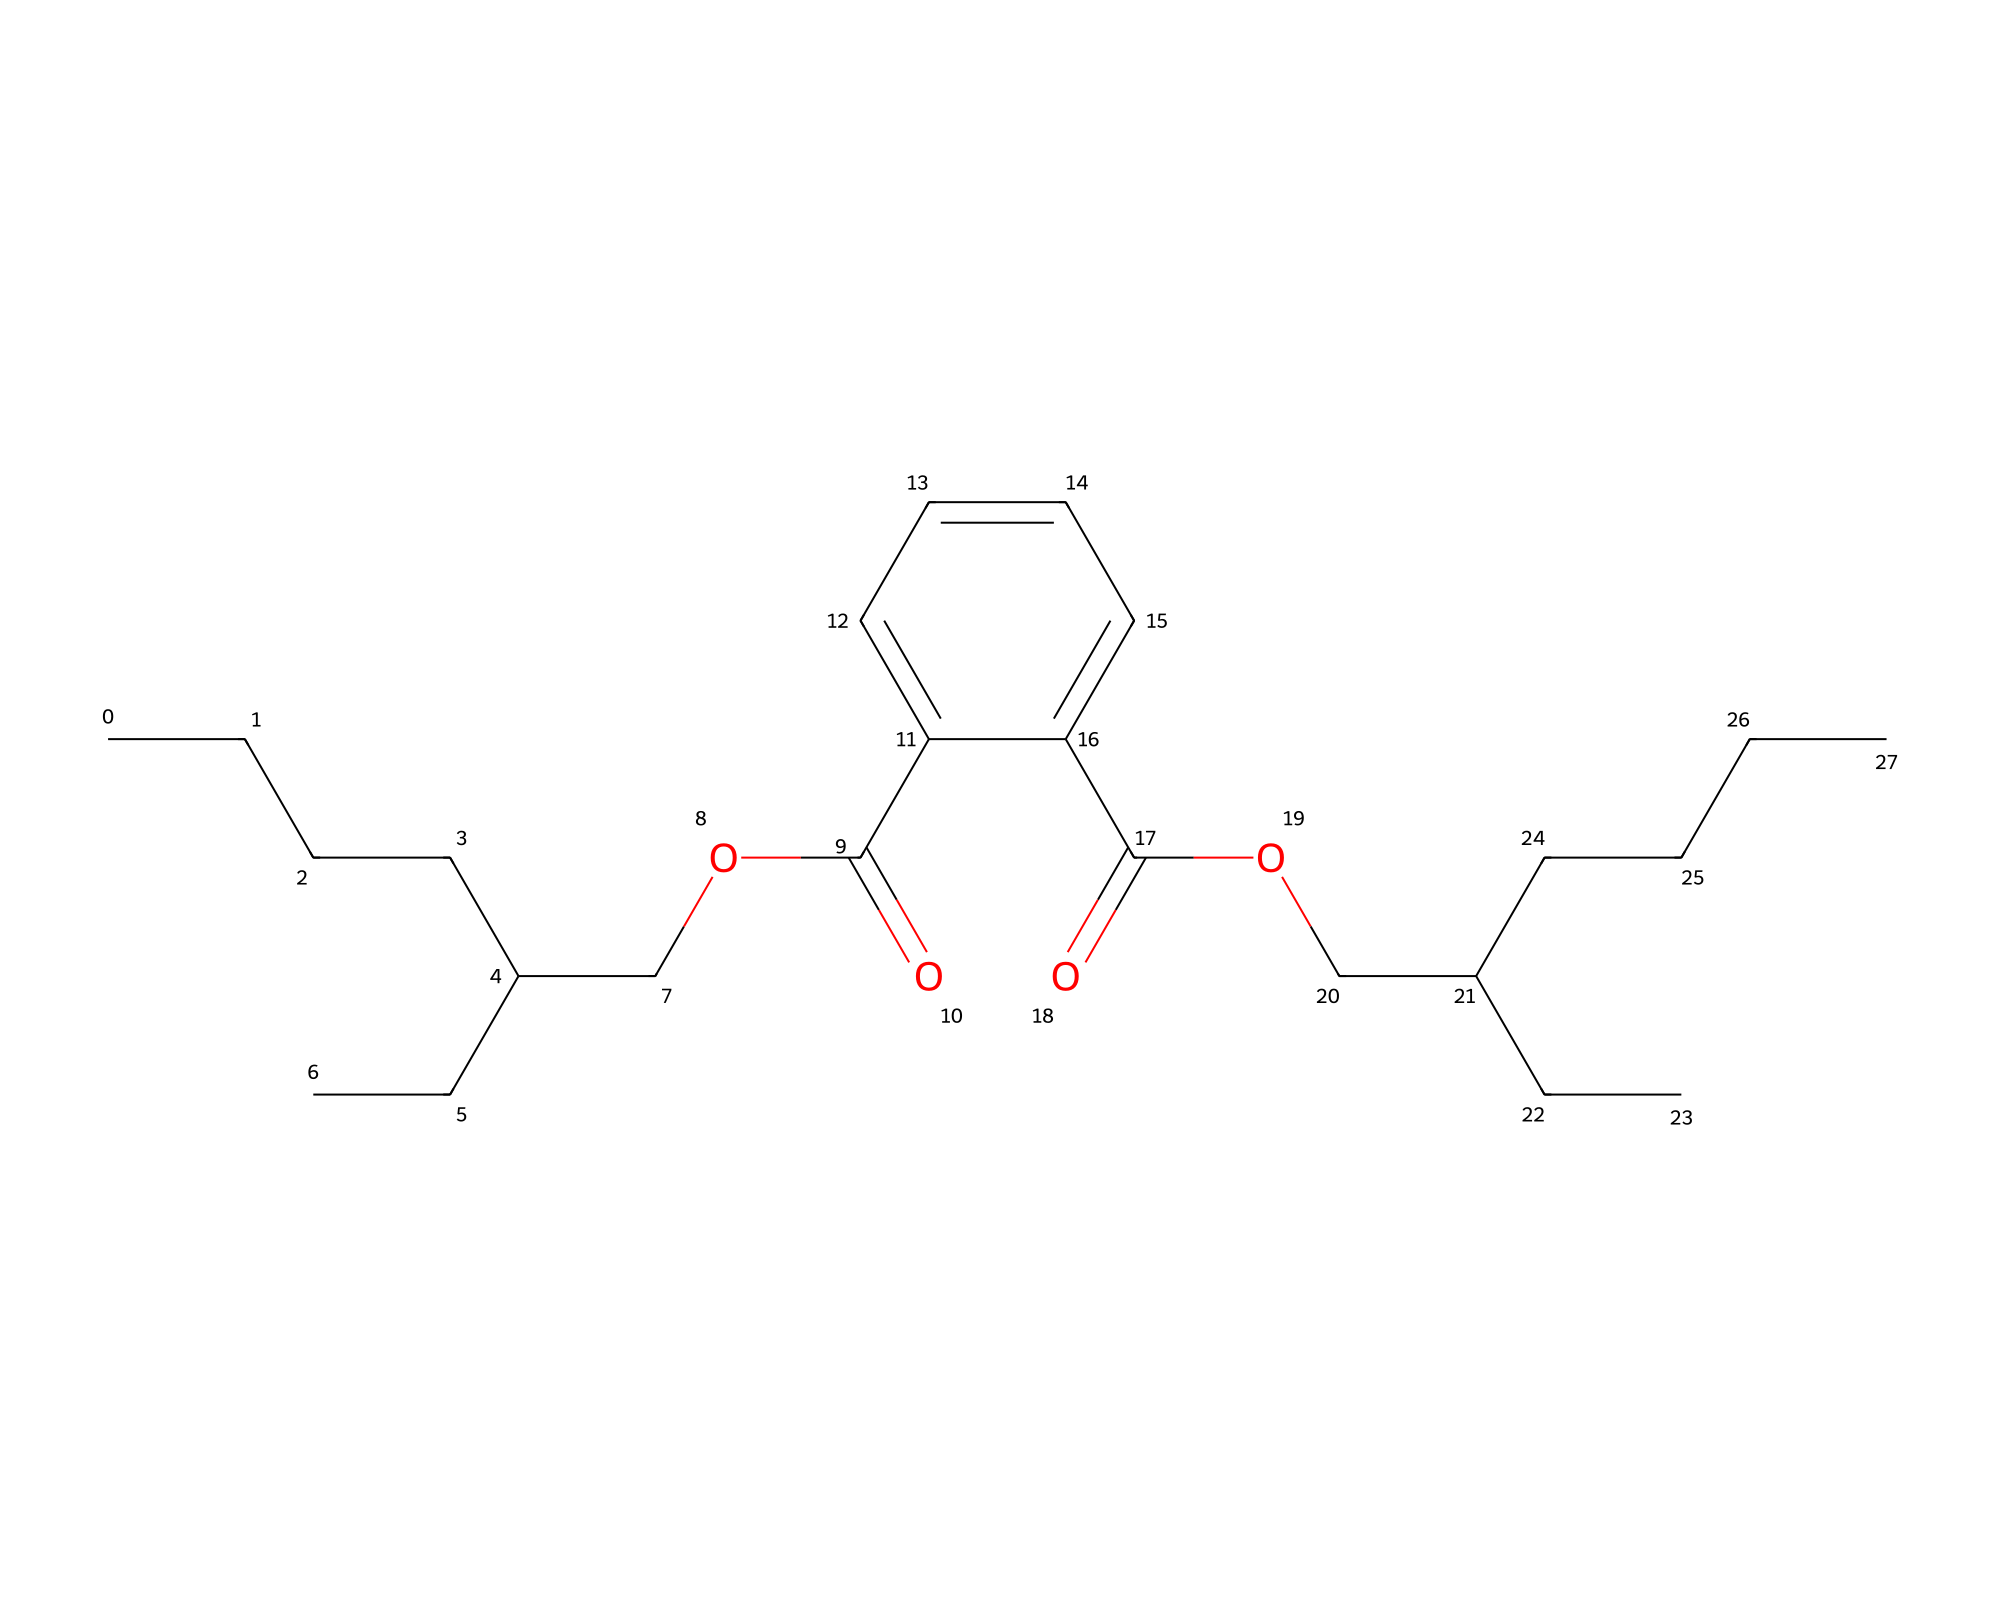

In [26]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

# 你的 SMILES 结构
smiles = "CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC"  # 请替换为你的正确 SMILES
mol = Chem.MolFromSmiles(smiles)
Chem.rdDepictor.Compute2DCoords(mol)  # 计算2D坐标

# 给每个原子编号
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("atomNote", str(i))  # 设置原子标签（编号）

# 创建一个绘图对象
drawer = rdMolDraw2D.MolDraw2DCairo(2000, 1600)  # 高分辨率绘制
options = drawer.drawOptions()

# 调整标签（原子编号）的字体大小
options.atomLabelFontSize = 50  # 默认是 10，可以增大
options.dotsPerAngstrom = 300  # 提高分辨率，使字体更清晰

# 绘制分子
drawer.DrawMolecule(mol)
drawer.FinishDrawing()

# 保存高清图片
with open("molecule_with_labels.png", "wb") as f:
    f.write(drawer.GetDrawingText())

# 显示图片
from PIL import Image
img = Image.open("molecule_with_labels.png")
img.show()


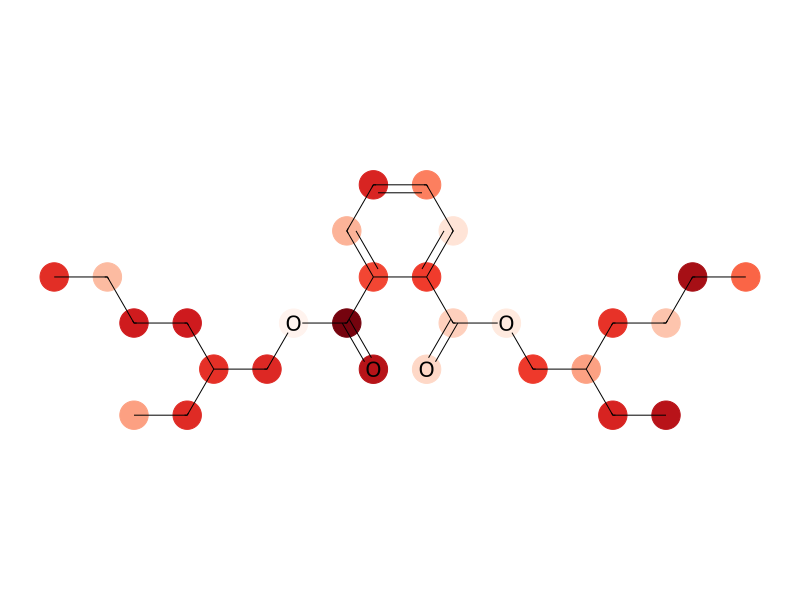

In [25]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import numpy as np
import matplotlib.pyplot as plt

# 你的 SMILES（请替换为你的实际分子）
smiles = "CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC"  # 示例分子
mol = Chem.MolFromSmiles(smiles)
Chem.rdDepictor.Compute2DCoords(mol)  # 计算2D坐标

# **确保 values 数据长度和分子原子数量匹配**
num_atoms = mol.GetNumAtoms()
values = np.random.rand(num_atoms)  # 示例数据，确保长度和分子原子数一致

# **生成颜色映射，只应用于原子**
heatmap_colors = {i: tuple(plt.cm.Reds(v)[:3]) for i, v in enumerate(values)}  # 取 RGB 部分

# **RDKit 进行分子绘制**
drawer = rdMolDraw2D.MolDraw2DCairo(800, 600)  # 设置高分辨率
options = drawer.drawOptions()
options.includeAtomNumbers = True  # 显示原子编号
options.bondLineWidth = 1  # 保持化学键线条宽度，避免 RDKit 自动加粗

# **关键：仅高亮原子，不高亮化学键**
highlight_atoms = list(heatmap_colors.keys())  # 需要着色的原子索引
drawer.DrawMolecule(
    mol, 
    highlightAtoms=highlight_atoms, 
    highlightAtomColors=heatmap_colors, 
    highlightBonds=[],  # 确保化学键不被高亮
    highlightAtomRadii={i: 0.4 for i in highlight_atoms}  # 设定原子颜色范围
)
drawer.FinishDrawing()

# 保存并显示图片
with open("molecule_colored_atoms_only.png", "wb") as f:
    f.write(drawer.GetDrawingText())

# 显示分子图像
from PIL import Image
img = Image.open("molecule_colored_atoms_only.png")
img.show()


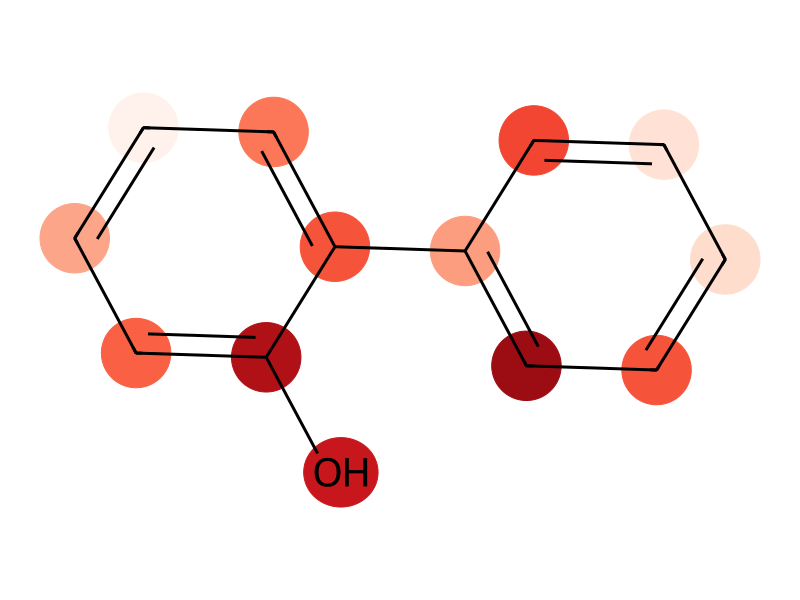

In [24]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import numpy as np
import matplotlib.pyplot as plt

# 你的 SMILES（请替换为你的实际分子）
smiles = "C1=CC=C(C=C1)C2=CC=CC=C2O"  # 示例分子
mol = Chem.MolFromSmiles(smiles)
Chem.rdDepictor.Compute2DCoords(mol)  # 计算2D坐标

# **确保 values 数据长度和分子原子数量匹配**
num_atoms = mol.GetNumAtoms()
values = np.random.rand(num_atoms)  # 示例数据，确保长度和分子原子数一致

# **设置透明度 (alpha)**，透明度值 A 介于 0.0（完全透明）和 1.0（不透明）
alpha = 1  # 你可以调整这个值，例如 0.3, 0.7

# **生成颜色映射，并设置透明度**
heatmap_colors = {i: (*plt.cm.Reds(v)[:3], alpha) for i, v in enumerate(values)}  # 取 RGB 部分，并加入 alpha 通道

# **RDKit 进行分子绘制**
drawer = rdMolDraw2D.MolDraw2DCairo(800, 600)  # 设置高分辨率
options = drawer.drawOptions()
options.includeAtomNumbers = True  # 显示原子编号
options.bondLineWidth = 3  # **增加化学键线条宽度**
options.useBWAtomPalette()  # **确保化学键保持黑色**

# **关键：仅高亮原子，不高亮化学键**
highlight_atoms = list(heatmap_colors.keys())  # 需要着色的原子索引
drawer.DrawMolecule(
    mol, 
    highlightAtoms=highlight_atoms, 
    highlightAtomColors=heatmap_colors, 
    highlightBonds=[],  # 确保化学键不被高亮
    highlightAtomRadii={i: 0.4 for i in highlight_atoms}  # 设定原子颜色范围
)
drawer.FinishDrawing()

# 保存并显示图片
with open("molecule_colored_atoms_thick_bonds.png", "wb") as f:
    f.write(drawer.GetDrawingText())

# 显示分子图像
from PIL import Image
img = Image.open("molecule_colored_atoms_thick_bonds.png")
img.show()


Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
SELFIES Tokens: ['[C]', '[C]', '[C]', '[C]', '[C]', '[Branch1]', '[Ring1]', '[C]', '[C]', '[C]', '[O]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[C]', '[=Branch1]', '[C]', '[=O]', '[O]', '[C]', '[C]', '[Branch1]', '[Ring1]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]']
Attention Weights: [0.01511048 0.01422806 0.02177957 0.02081949 0.02025755 0.01410715
 0.02157465 0.02434386 0.02126538 0.01892392 0.01876076 0.0178229
 0.02810278 0.02587247 0.03270281 0.02967719 0.01900375 0.0271191
 0.01488563 0.01968455 0.01486319 0.0234333  0.03707237 0.03403392
 0.05191687 0.03795448 0.0298163  0.06870537 0.03232319 0.04994794
 0.01655988 0.02452497 0.02886822 0.01879047 0.01628274 0.01656318
 0.01719171 0.01795822]
警告：SELFIES tokens 数量（38）与 RDKit 原子数（28）不匹配！


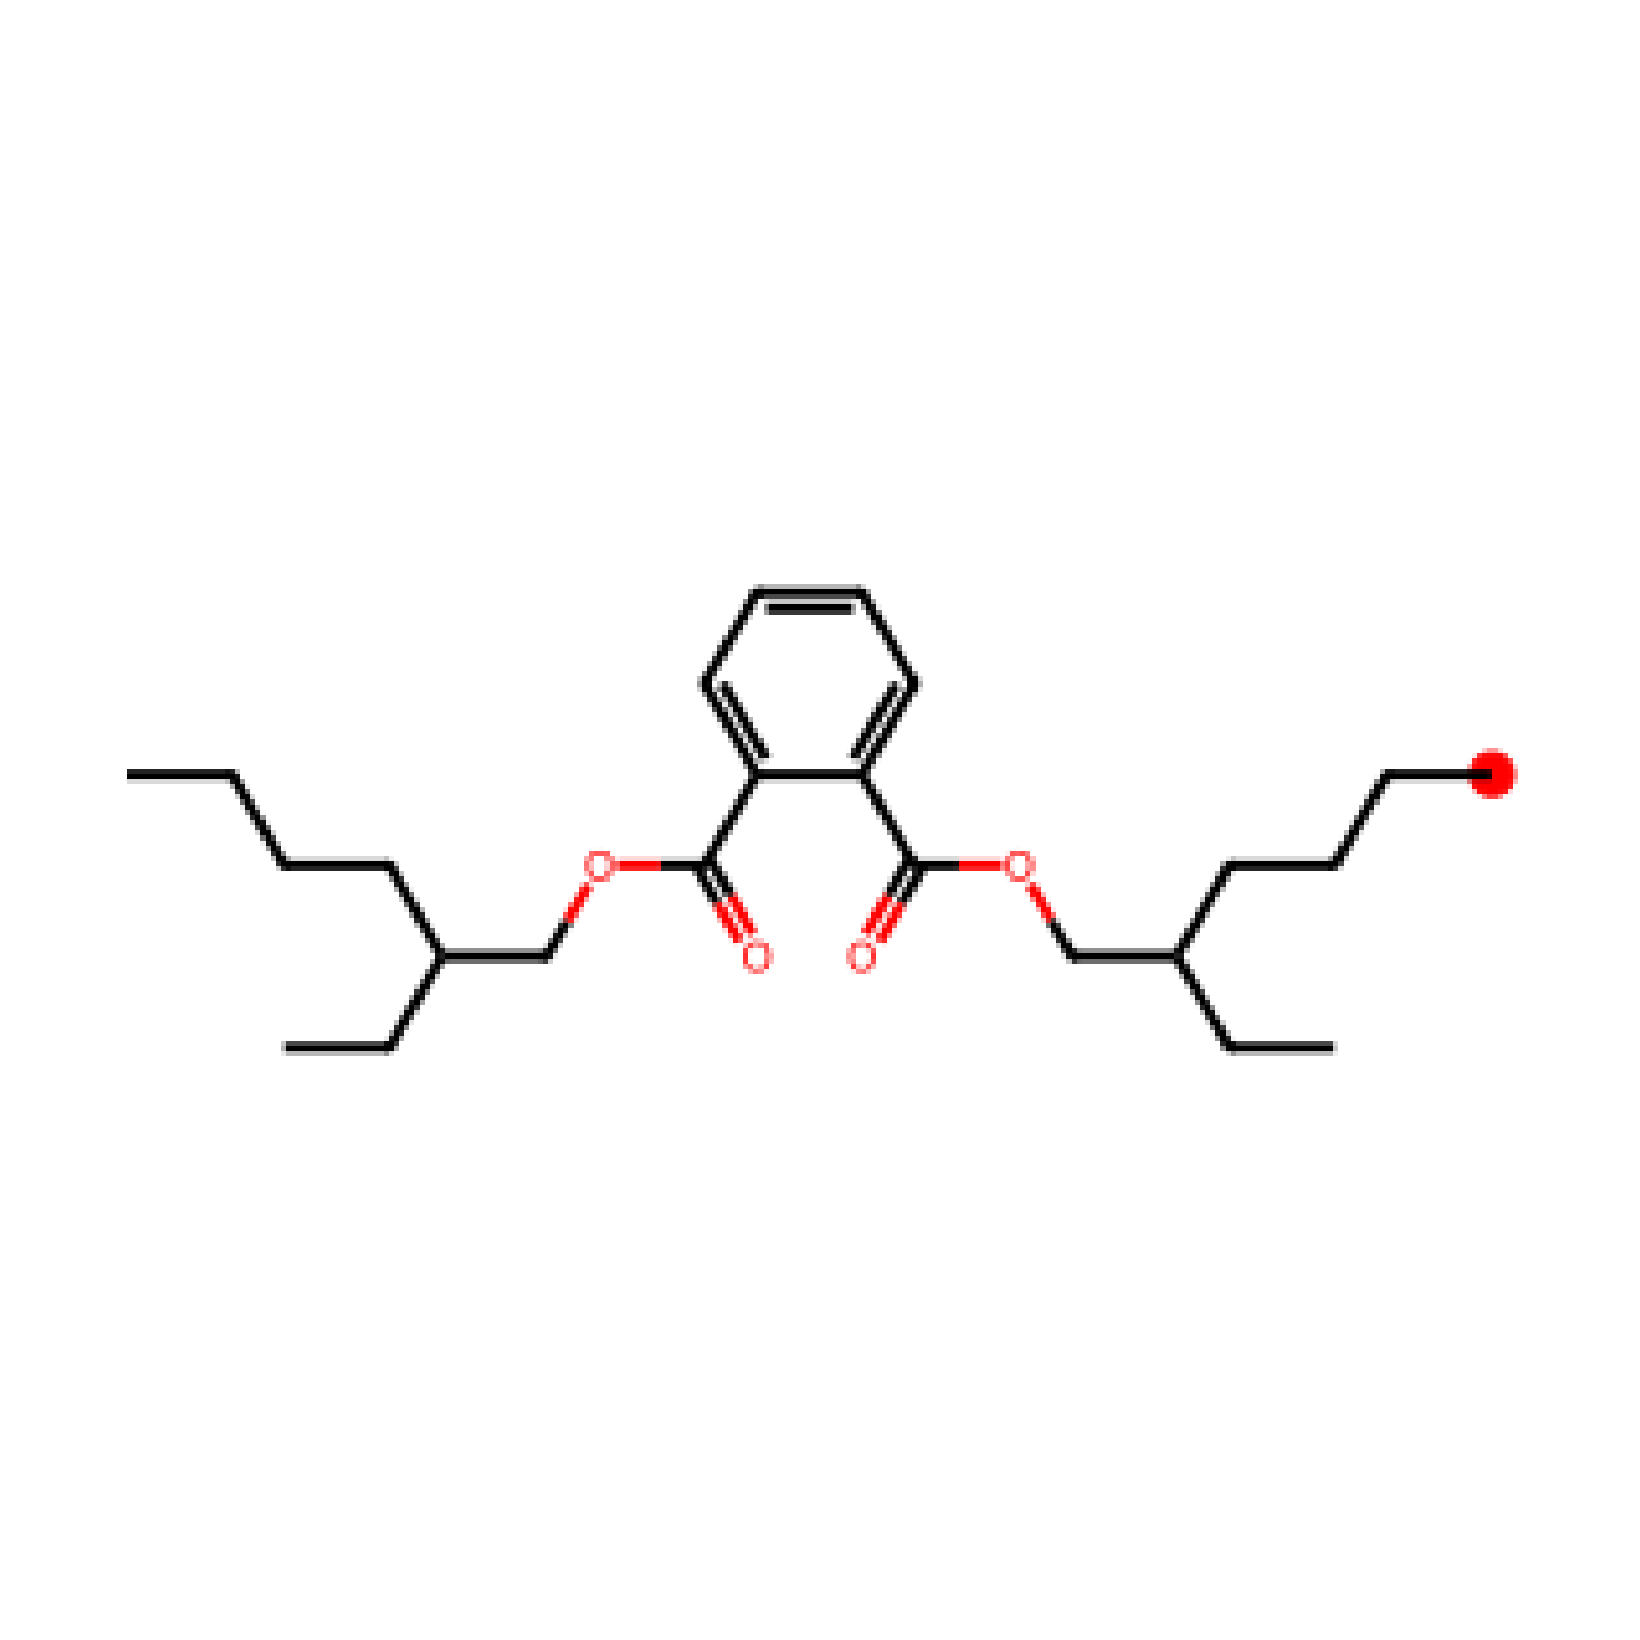

In [25]:
smiles_example = "CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC"  # 示例 SMILES
tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
print("SELFIES Tokens:", tokens)
print("Attention Weights:", weights)

visualize_attention(smiles_example, tokens, weights, highlight_percent=0)

Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
SELFIES Tokens: ['[C]', '[C]', '[Branch1]', '[P]', '[C]', '[C]', '[C]', '[C]', '[Ring1]', '[Branch1]', '[Branch1]', '[Branch2]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[Ring1]', '[#Branch1]', '[C]', '[C]']
Attention Weights: [0.02283091 0.03131832 0.02992348 0.04696214 0.03811198 0.03090031
 0.02657512 0.02846894 0.03364143 0.02800991 0.03100776 0.05512889
 0.04737594 0.05229268 0.06313276 0.05118589 0.0825332  0.06516011
 0.06455851 0.05194089 0.05476765]
警告：SELFIES tokens 数量（21）与 RDKit 原子数（11）不匹配！


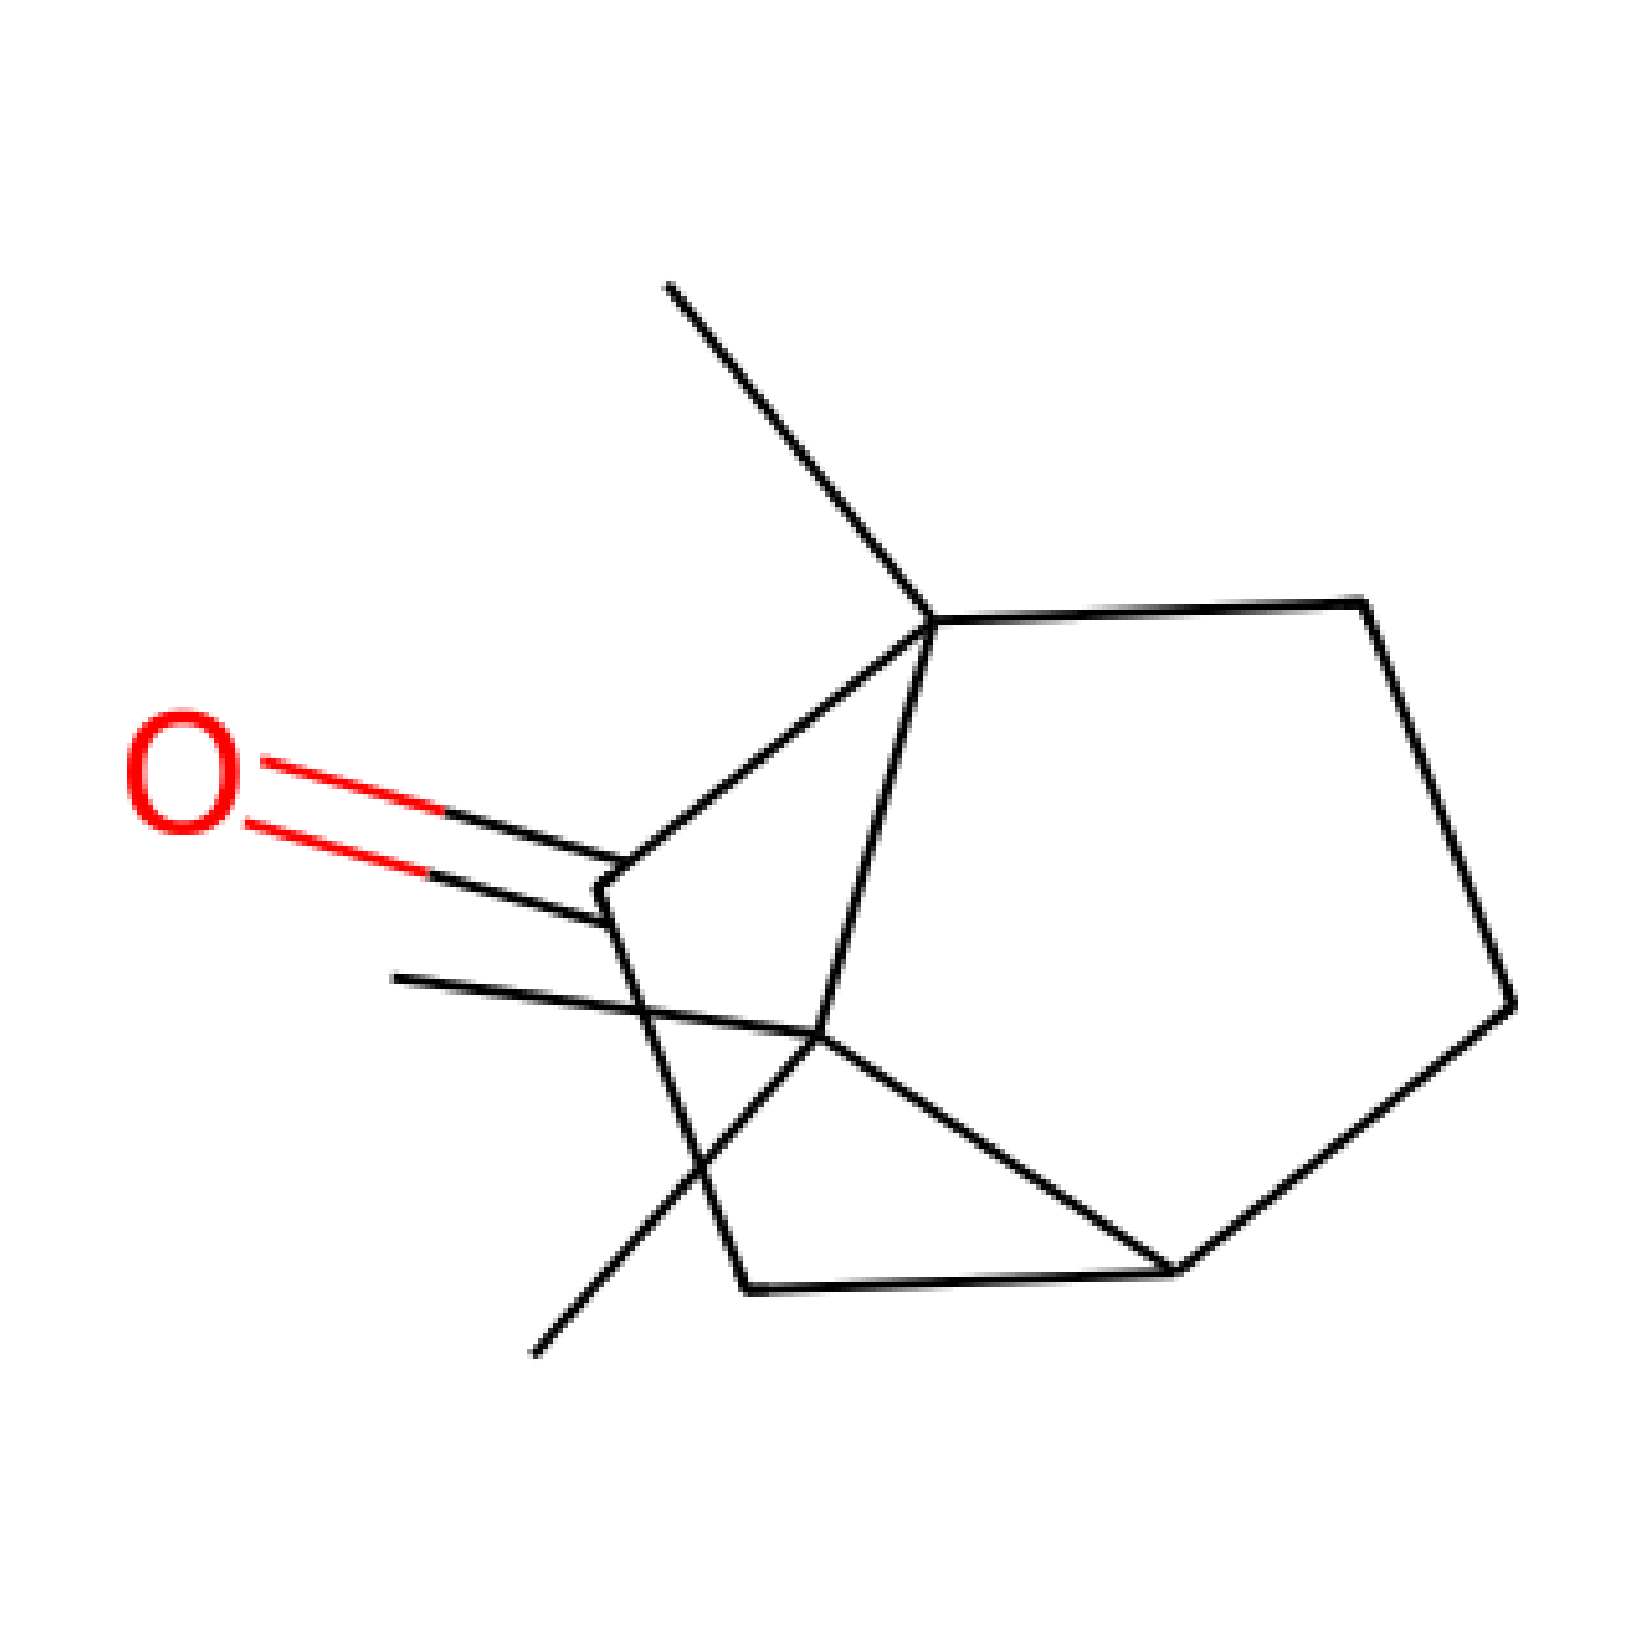

In [24]:
smiles_example = "CC1(C2CCC1(C(=O)C2)C)C"  # 示例 SMILES
tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
print("SELFIES Tokens:", tokens)
print("Attention Weights:", weights)

visualize_attention(smiles_example, tokens, weights, highlight_percent=20)

In [27]:
from collections import defaultdict

def compute_dataset_average_weight_by_symbol(smiles_data, model, tokenizer, device):
    """
    对整个SMILES数据集，按原子符号区分，计算各符号的平均注意力权重。
    返回一个字典：{原子符号: 平均权重}
    """
    # 用字典记录每种原子符号的权重列表
    symbol_weights = defaultdict(list)

    for smiles in smiles_data:
        tokens, weights = compute_self_attention_weights(smiles, model, tokenizer, device)

        for t, w in zip(tokens, weights):
            # 过滤掉分支/环符号
            if t not in ["[Branch1]", "[Branch2]", "[Ring1]", "[Ring2]"]:
                symbol_weights[t].append(w)

    # 计算平均值
    avg_dict = {}
    for symbol, w_list in symbol_weights.items():
        if len(w_list) > 0:
            avg_dict[symbol] = sum(w_list) / len(w_list)
        else:
            avg_dict[symbol] = 0.0

    return avg_dict

# 示例调用
symbol_avg_dict = compute_dataset_average_weight_by_symbol(smiles_data, model, tokenizer_instance, device)
print("各原子符号的平均注意力权重:")
for sym, avg_w in symbol_avg_dict.items():
    print(sym, ":", avg_w)


Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
Input IDs Shape: torch.Size(

In [ ]:
[C] : 0.06910326
[P] : 0.041986074
[O] : 0.078830585
[N+1] : 0.049981248
[=Branch1] : 0.064654544
[=O] : 0.06912473
[O-1] : 0.069429986
[=C] : 0.040766984
[#Branch1] : 0.068066
[Cl] : 0.09567906
[#N] : 0.10505723
[N] : 0.08566408
[Br] : 0.14746967
[S] : 0.111683786
[=Branch2] : 0.04672559
[=N] : 0.04332977
[#Branch2] : 0.059870083
[#C] : 0.12494355
[=S] : 0.06254192
[F] : 0.09417917
[=N+1] : 0.03180132
[=N-1] : 0.019939277
. : 0.008095078

In [ ]:


[O] : 0.078830585
[Cl] : 0.09567906
[#N] : 0.10505723
[N] : 0.08566408
[Br] : 0.14746967
[S] : 0.111683786
[#C] : 0.12494355
[F] : 0.09417917


In [12]:
import matplotlib.pyplot as plt

# 数据
elements = ["O", "Cl", "#N", "N", "Br", "S", "#C", "F"]
values = [0.078830585, 0.09567906, 0.10505723, 0.08566408, 0.14746967, 0.111683786, 0.12494355, 0.09417917]



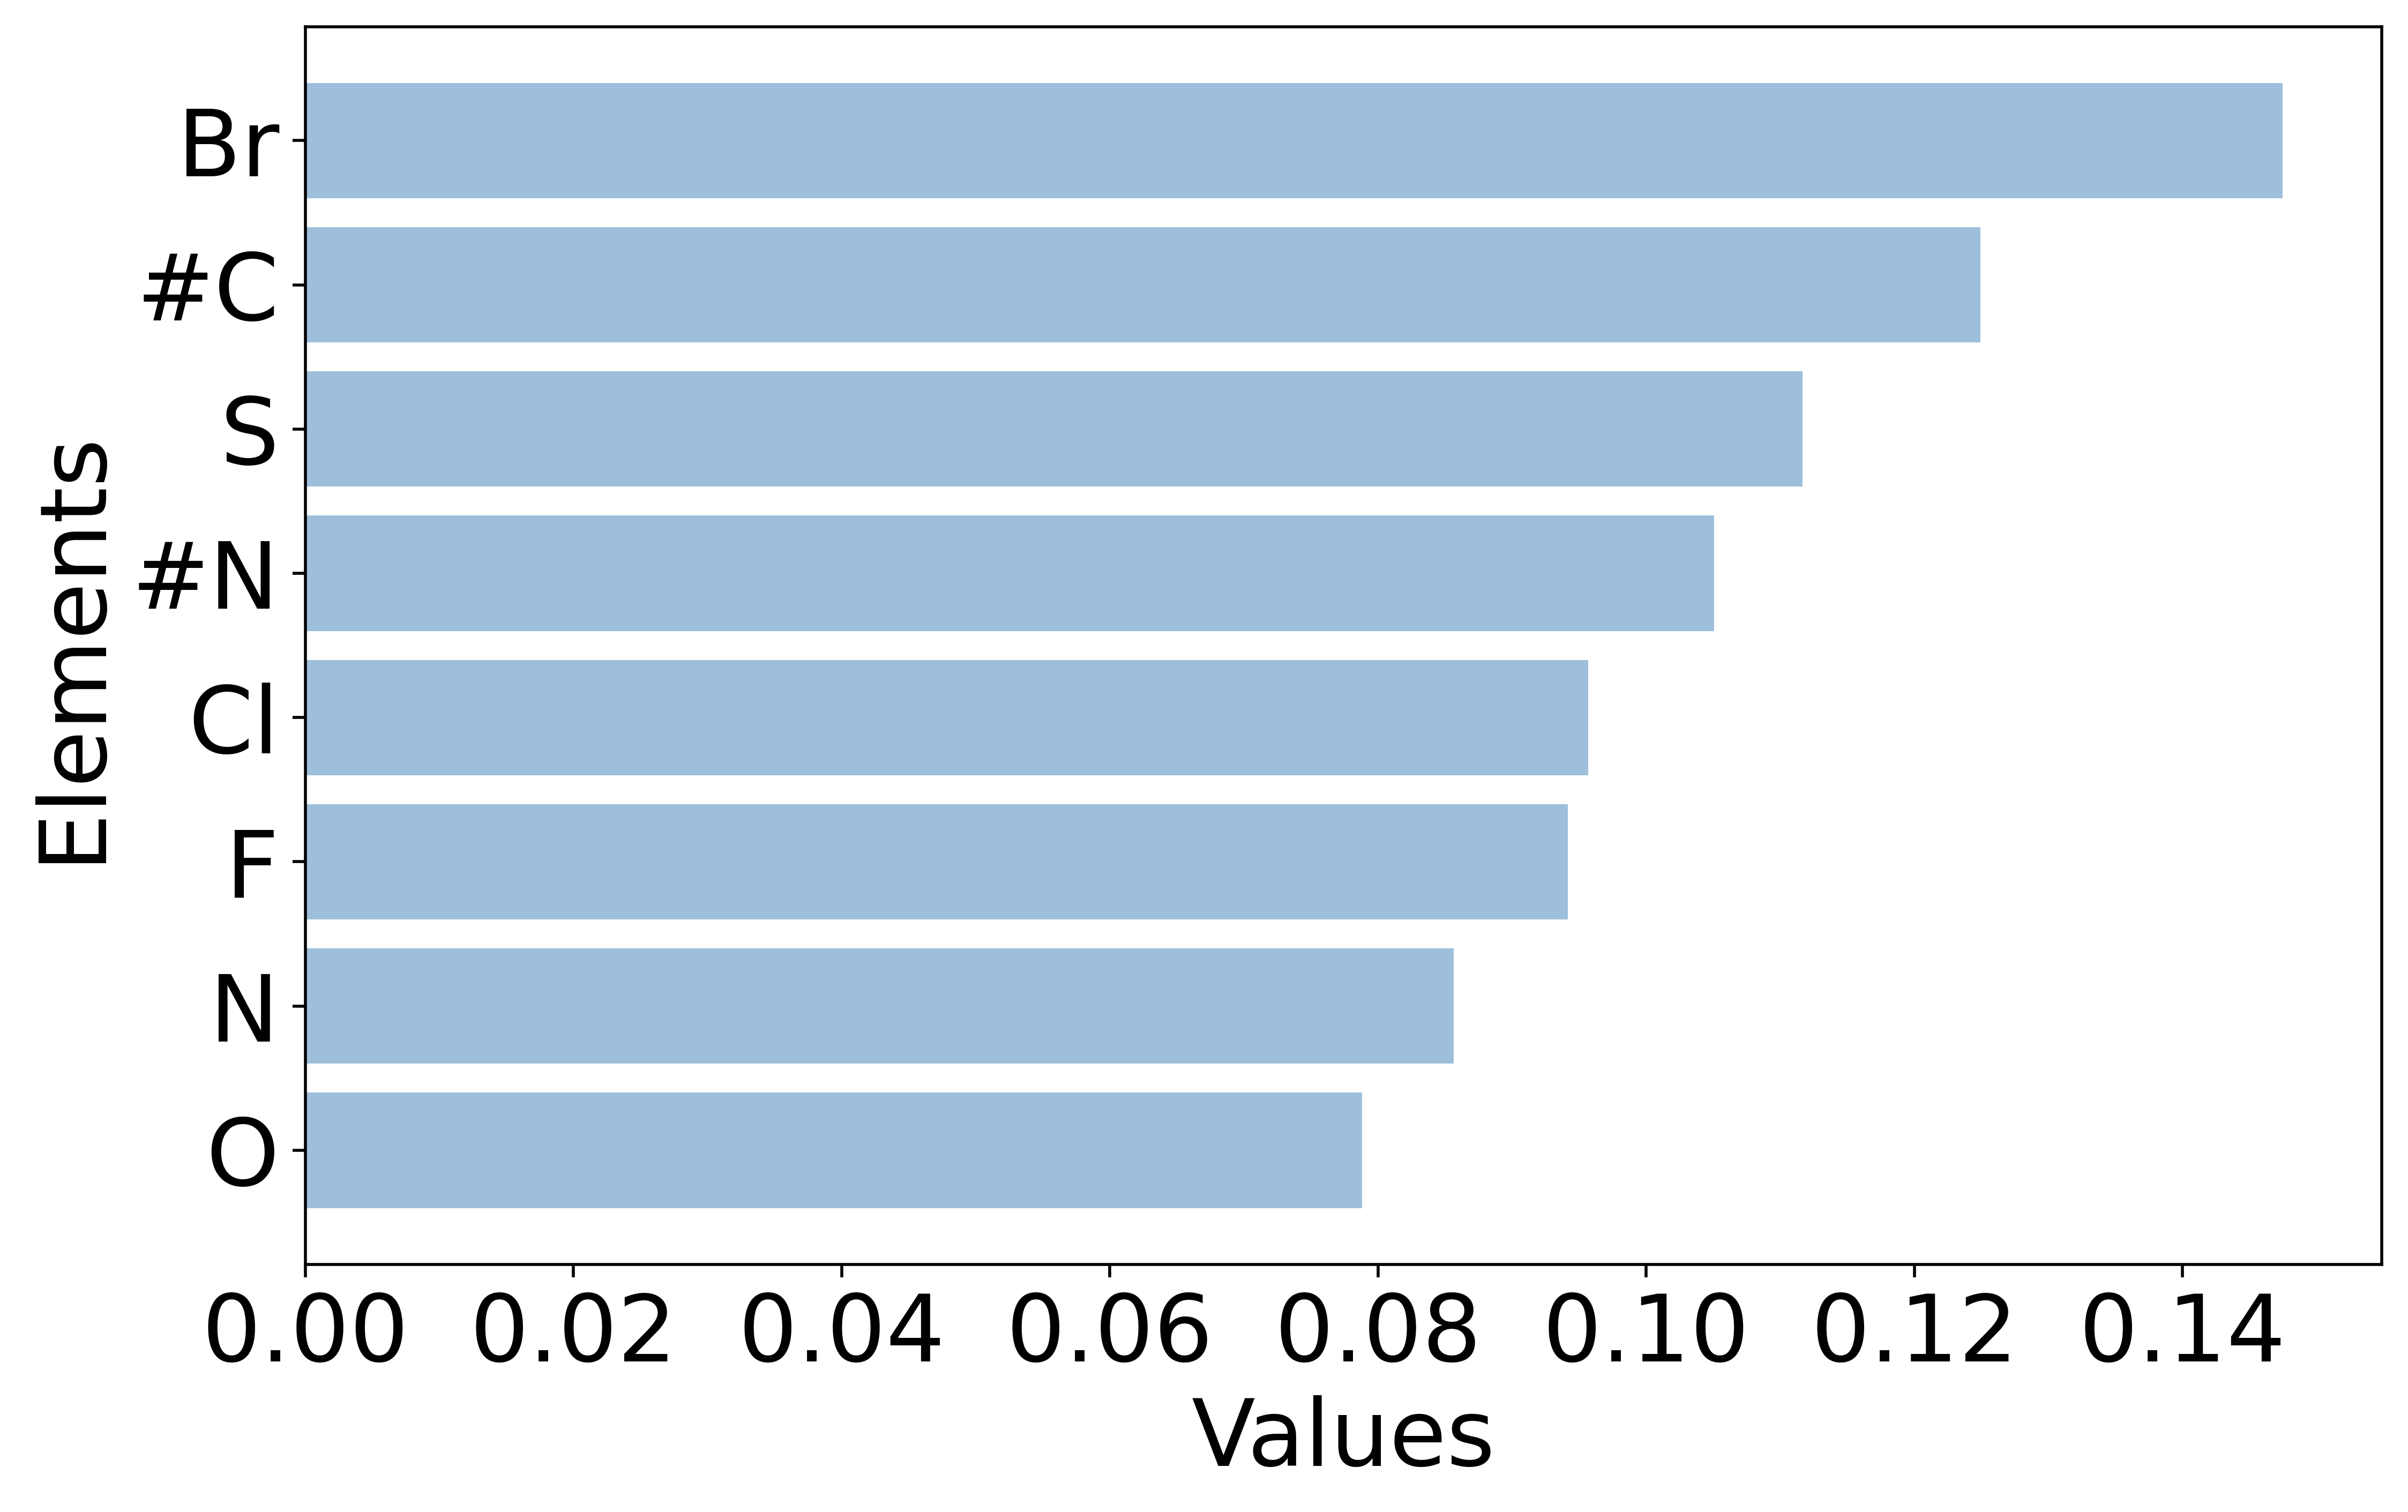

In [13]:
# 按值从大到小排序
sorted_indices = sorted(range(len(values)), key=lambda i: values[i], reverse=True)
sorted_elements = [elements[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]

# 绘制横向柱状图
plt.figure(figsize=(10, 6),dpi=500)
plt.barh(sorted_elements, sorted_values, color='#9DBFDC')

# 反转y轴，使最高值在最上方
plt.gca().invert_yaxis()
# 调整刻度字体大小
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# 添加标签和标题
plt.xlabel("Values",fontsize=25)
plt.ylabel("Elements", fontsize=25)
#plt.title("Sorted Horizontal Bar Chart of Element Values")

# 显示图表
plt.show()

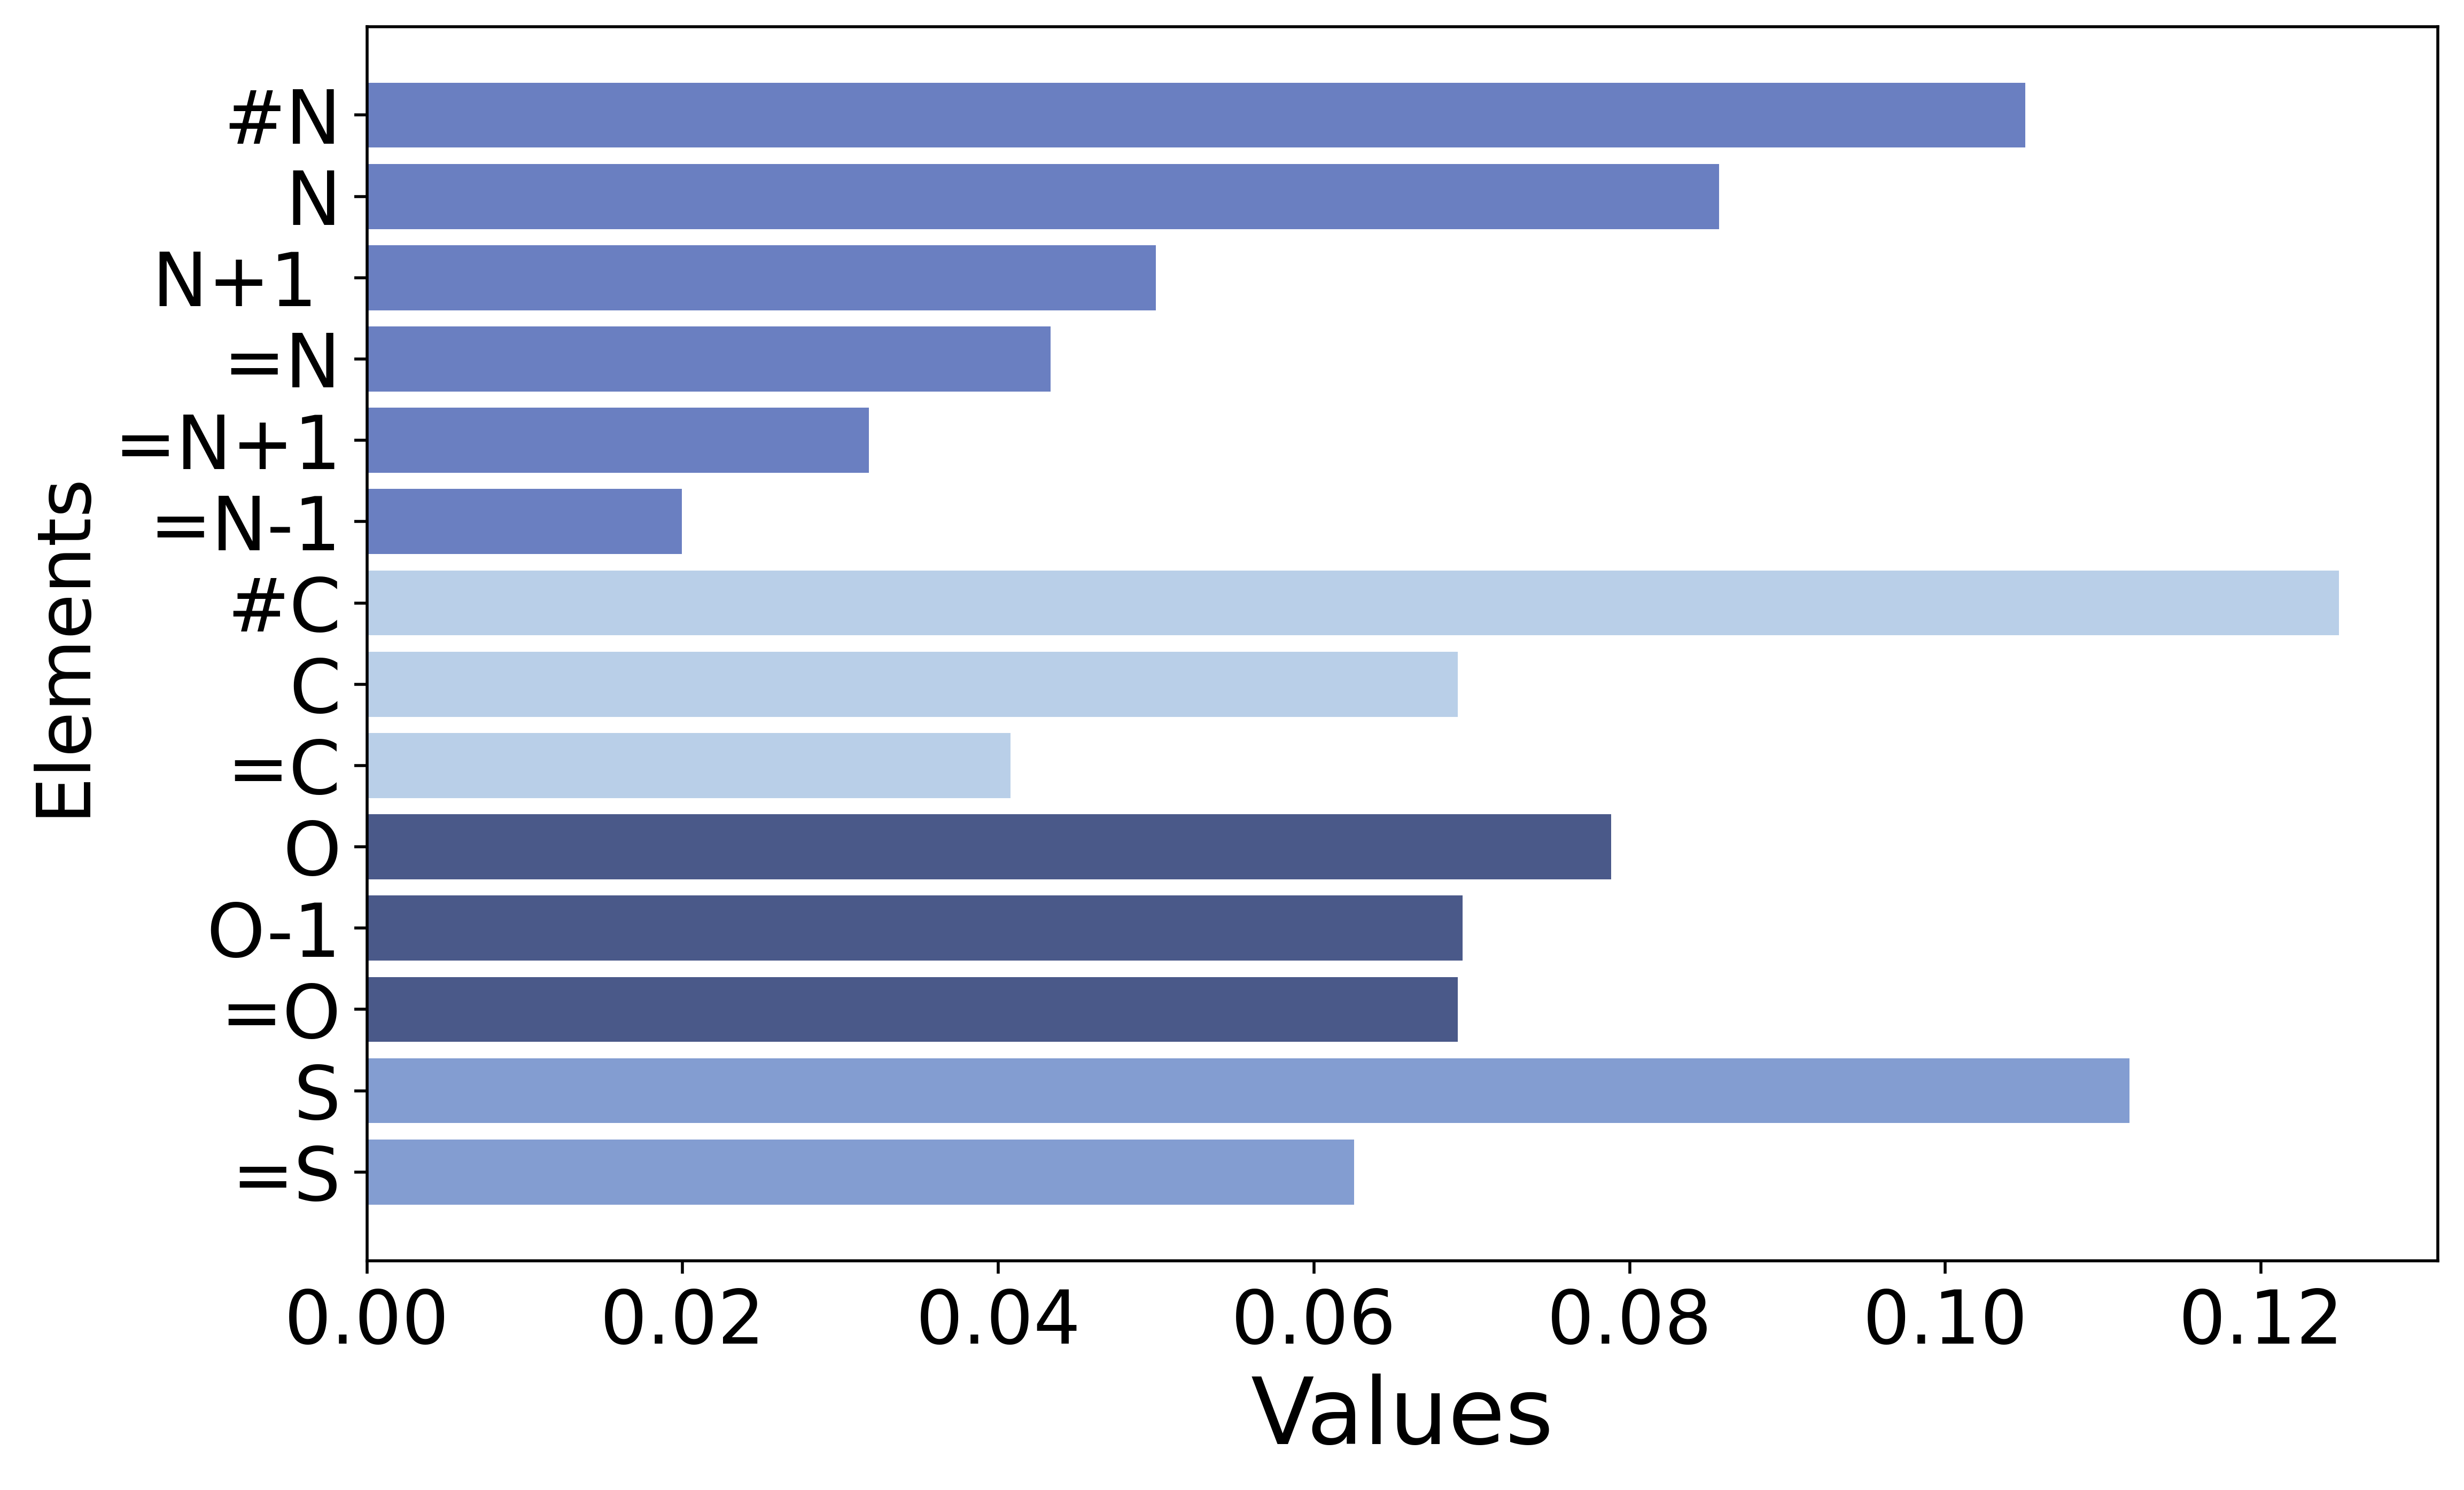

In [2]:
import matplotlib.pyplot as plt

elements = ["#N", "N", "N+1 ", "=N", "=N+1", "=N-1",
            "#C","C","=C",
            "O","O-1","=O",
            "S","=S"]
values = [0.10505723, 0.08566408, 0.049981248, 0.04332977, 0.03180132, 0.019939277,
          0.12494355,0.06910326,0.040766984,
          0.078830585,0.069429986,0.06912473,
          0.111683786,0.06254192]


# [#N] : 0.10505723
# [N] : 0.08566408
# [N+1] : 0.049981248
# [=N] : 0.04332977
# [=N+1] : 0.03180132
# [=N-1] : 0.019939277
# [=C] : 0.040766984
# [C] : 0.06910326
# [#C] : 0.12494355
# [=O] : 0.06912473
# [O-1] : 0.069429986
# [O] : 0.078830585
# [S] : 0.111683786
# [=S] : 0.06254192

# 按值从大到小排序
#sorted_indices = sorted(range(len(values)), key=lambda i: values[i], reverse=True)
#sorted_elements = [elements[i] for i in sorted_indices]
#sorted_values = [values[i] for i in sorted_indices]


# 颜色映射：根据原子类型分类
color_map = {
    "N": "#6A7FC1",   # 红色（氮）
    "C": "#B9CFE8",   # 蓝色（碳）
    "O": "#4A5989",   # 绿色（氧）
    "S": "#839DD1"    # 黄色（硫）
}

# 生成颜色列表
colors = [color_map["N"] if "N" in el else color_map["C"] if "C" in el else color_map["O"] if "O" in el else color_map["S"] for el in elements]

# 绘制横向柱状图
plt.figure(figsize=(10, 6), dpi=500)
plt.barh(elements, values, color=colors)




# # 绘制横向柱状图
# plt.figure(figsize=(10, 6),dpi=500)
# plt.barh(elements, values, color='#6A7FC1')

# 反转y轴，使最高值在最上方
plt.gca().invert_yaxis()
# 调整刻度字体大小
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# 添加标签和标题
plt.xlabel("Values",fontsize=25)
plt.ylabel("Elements", fontsize=20)
#plt.title("Sorted Horizontal Bar Chart of Element Values")

# 显示图表
plt.show()





In [ ]:
[=C] : 0.040766984
[C] : 0.06910326
[#C] : 0.12494355

In [ ]:
[#N] : 0.10505723
[N] : 0.08566408
[N+1] : 0.049981248
[=N] : 0.04332977
[=N+1] : 0.03180132
[=N-1] : 0.019939277

In [ ]:
[=O] : 0.06912473
[O-1] : 0.069429986
[O] : 0.078830585

In [ ]:
[S] : 0.111683786

[=S] : 0.06254192

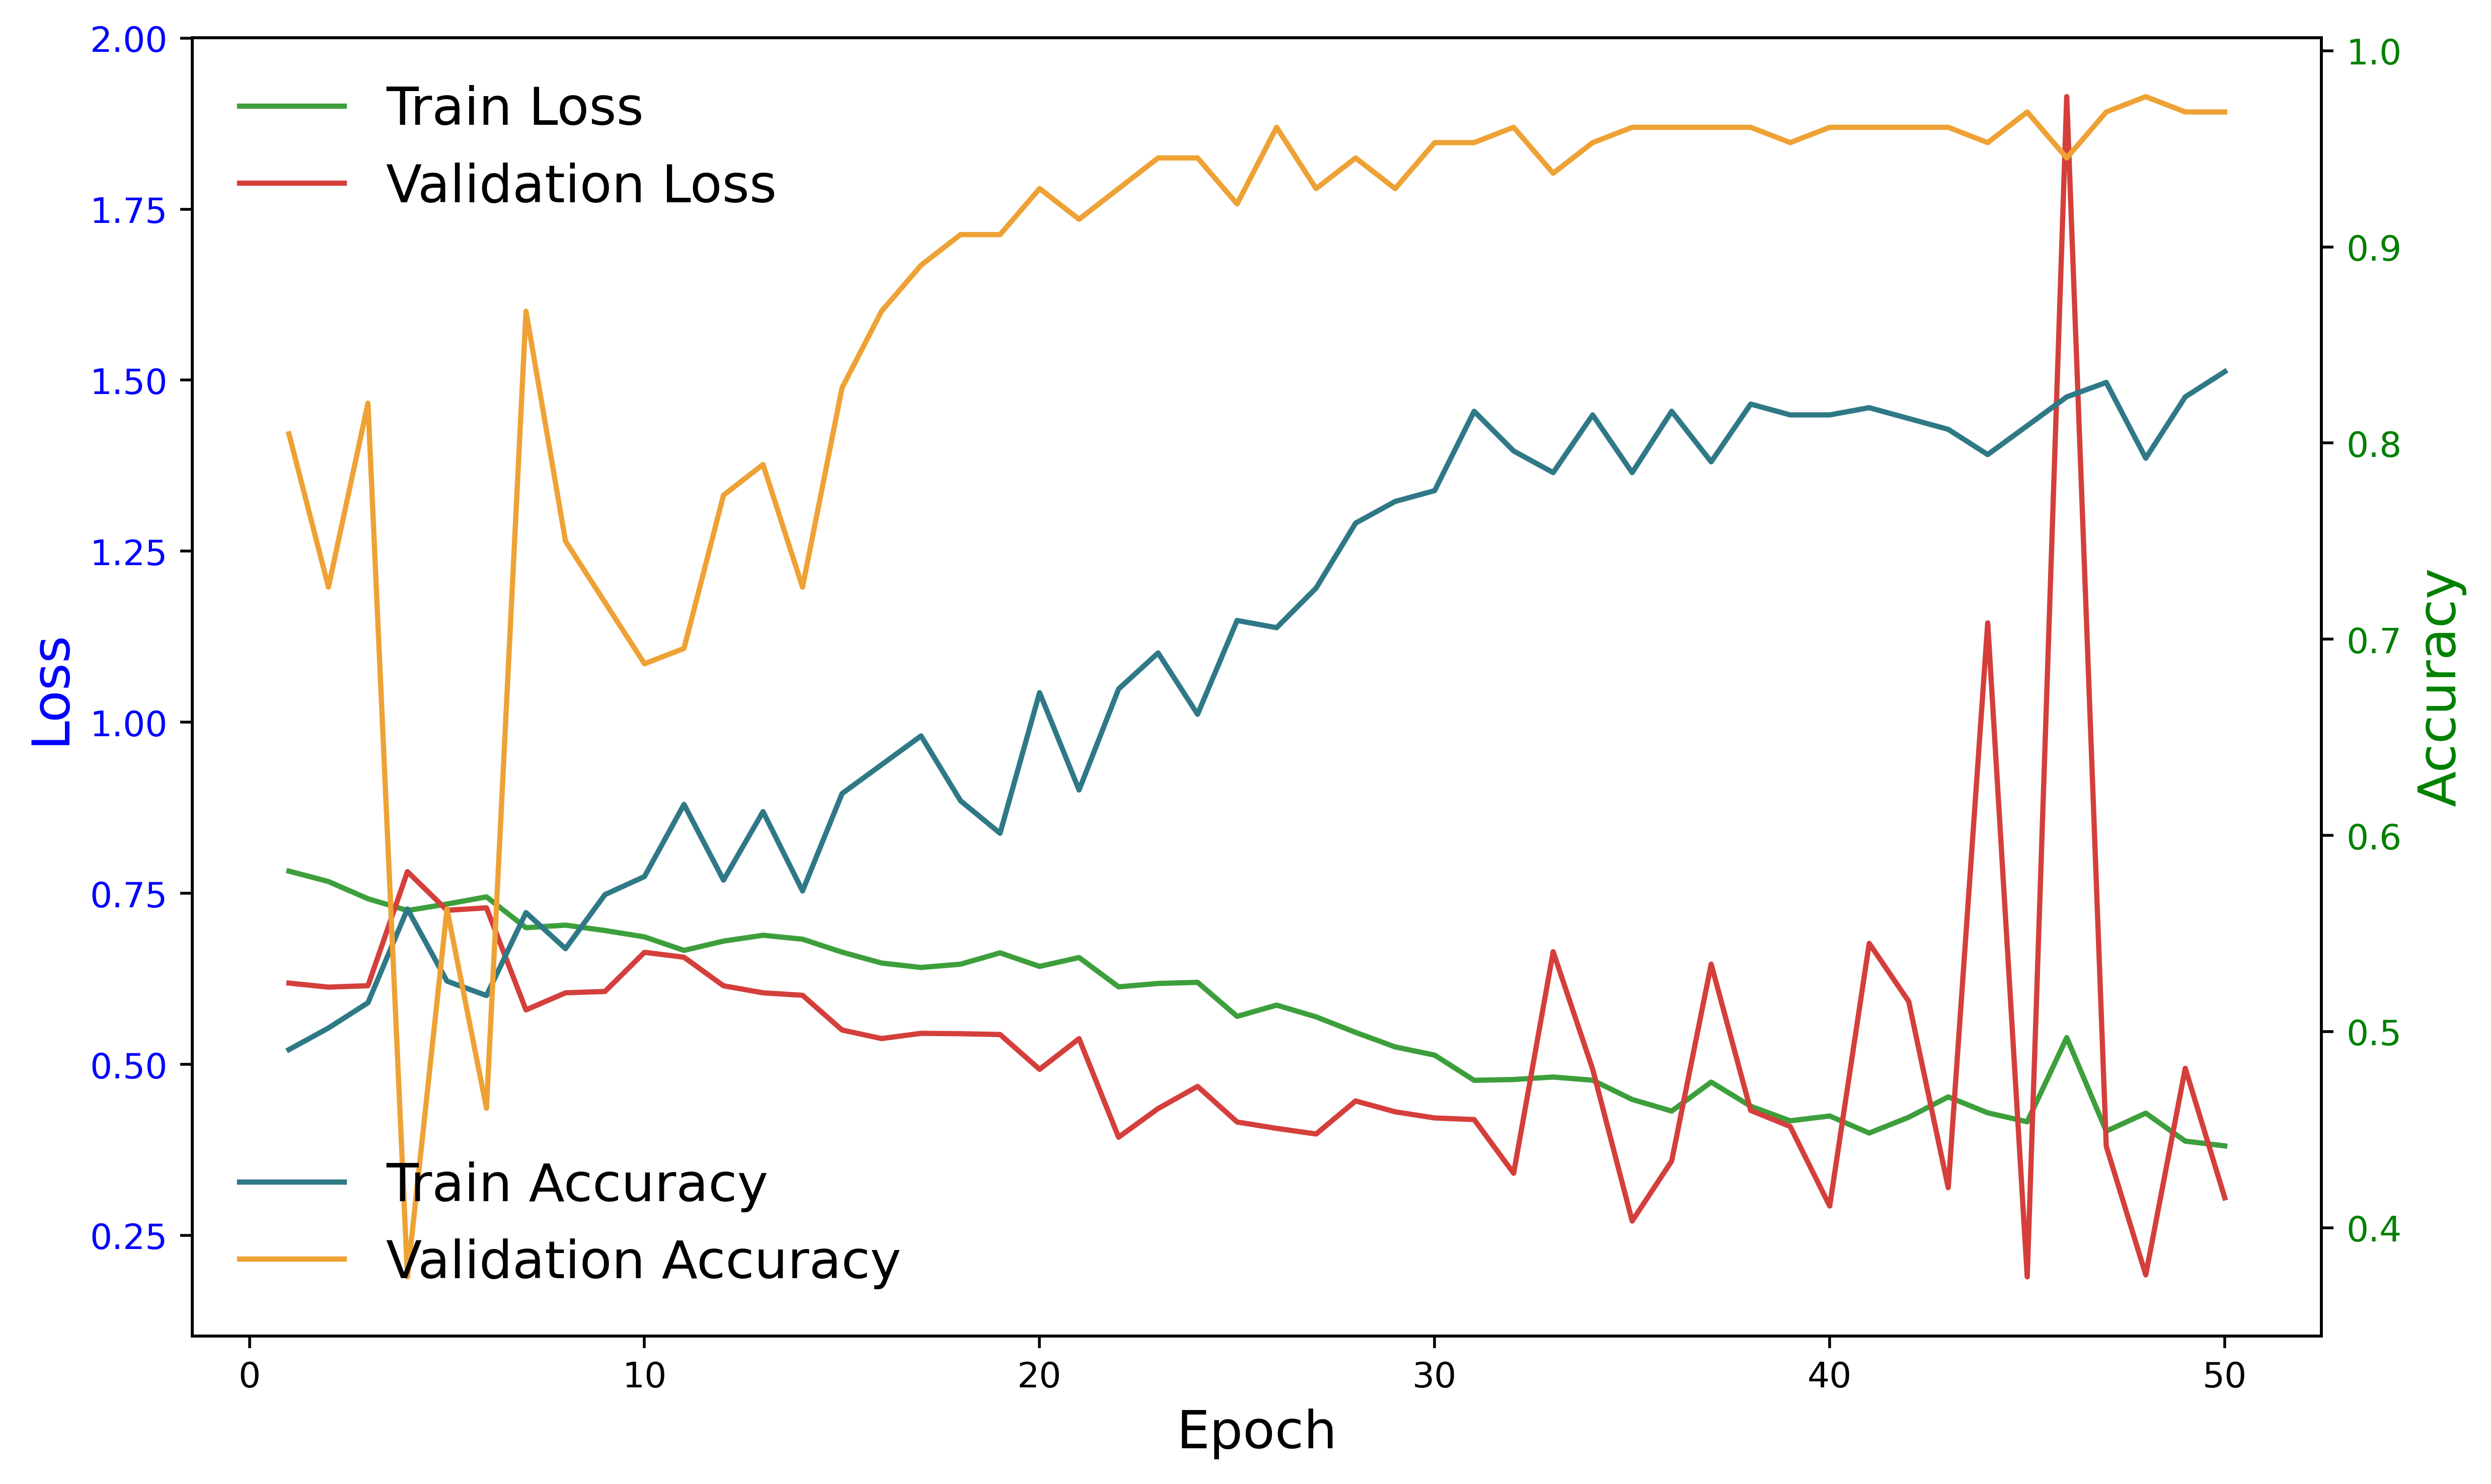

In [80]:

'''
# 读取保存的CSV文件
df = pd.read_csv('training_metrics.csv')

# 提取数据
num_epochs = 50
train_losses = df['Train Loss']
val_losses = df['Val Loss']
train_accuracies = df['Train Accuracy']
val_accuracies = df['Val Accuracy']
'''
import matplotlib.pyplot as plt

# 创建一个新的图形
plt.figure(figsize=(10, 6),dpi=500)

# 绘制损失曲线
ax1 = plt.gca()  # 获取当前坐标轴
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='#3D9F3C')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='#D43F3B')
ax1.set_xlabel('Epoch', fontsize=15)
ax1.set_ylabel('Loss', color='blue', fontsize=15)
ax1.tick_params(axis='y', labelcolor='blue')  # 设置y轴的刻度颜色
#ax1.set_title('Loss and Accuracy Curve')

# 创建第二个y轴来绘制准确率曲线
ax2 = ax1.twinx()  # 创建第二个Y轴共享X轴
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='#2F7987')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='#EEA235')
ax2.set_ylabel('Accuracy', color='green', fontsize=15)
ax2.tick_params(axis='y', labelcolor='green')  # 设置y轴的刻度颜色

# 添加图例
ax1.legend(loc='upper left', frameon=False,fontsize=15)
ax2.legend(loc='lower left', frameon=False,fontsize=15)

# 显示图形
plt.tight_layout()
plt.show()

In [81]:
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Val Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies
})

# 将DataFrame保存为CSV文件
df.to_csv('training_metrics.csv', index=False)

In [83]:
torch.save(model.state_dict(), 'best_chemberta_model.pth')

In [84]:
# 加载最佳模型
model.load_state_dict(torch.load('./best_chemberta_model.pth'))

<All keys matched successfully>

In [89]:


# 提取 SMILES 的嵌入表示

# 提取 SMILES 的嵌入表示
def extract_embeddings(smiles_list, model, tokenizer, device):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for smiles in smiles_list:
            # 编码 SMILES
            tokens = tokenizer(smiles, padding='max_length', truncation=True, max_length=10, return_tensors="pt")
            # 将所有张量移动到指定设备上（例如 GPU）
            tokens = {key: val.to(device) for key, val in tokens.items()}
            
            # 通过 ChemBERTa 模型获得输出
            outputs = model.chemberta(**tokens)
            
            # 提取 [CLS] token 的嵌入作为 SMILES 的整体嵌入
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embedding)
    
    return np.vstack(embeddings)

# 提取嵌入
smiles_embeddings = extract_embeddings(smiles_data, model, tokenizer_instance, device)

In [90]:
np.save('./Toxicity_smiles_embeddings.npy',smiles_embeddings)

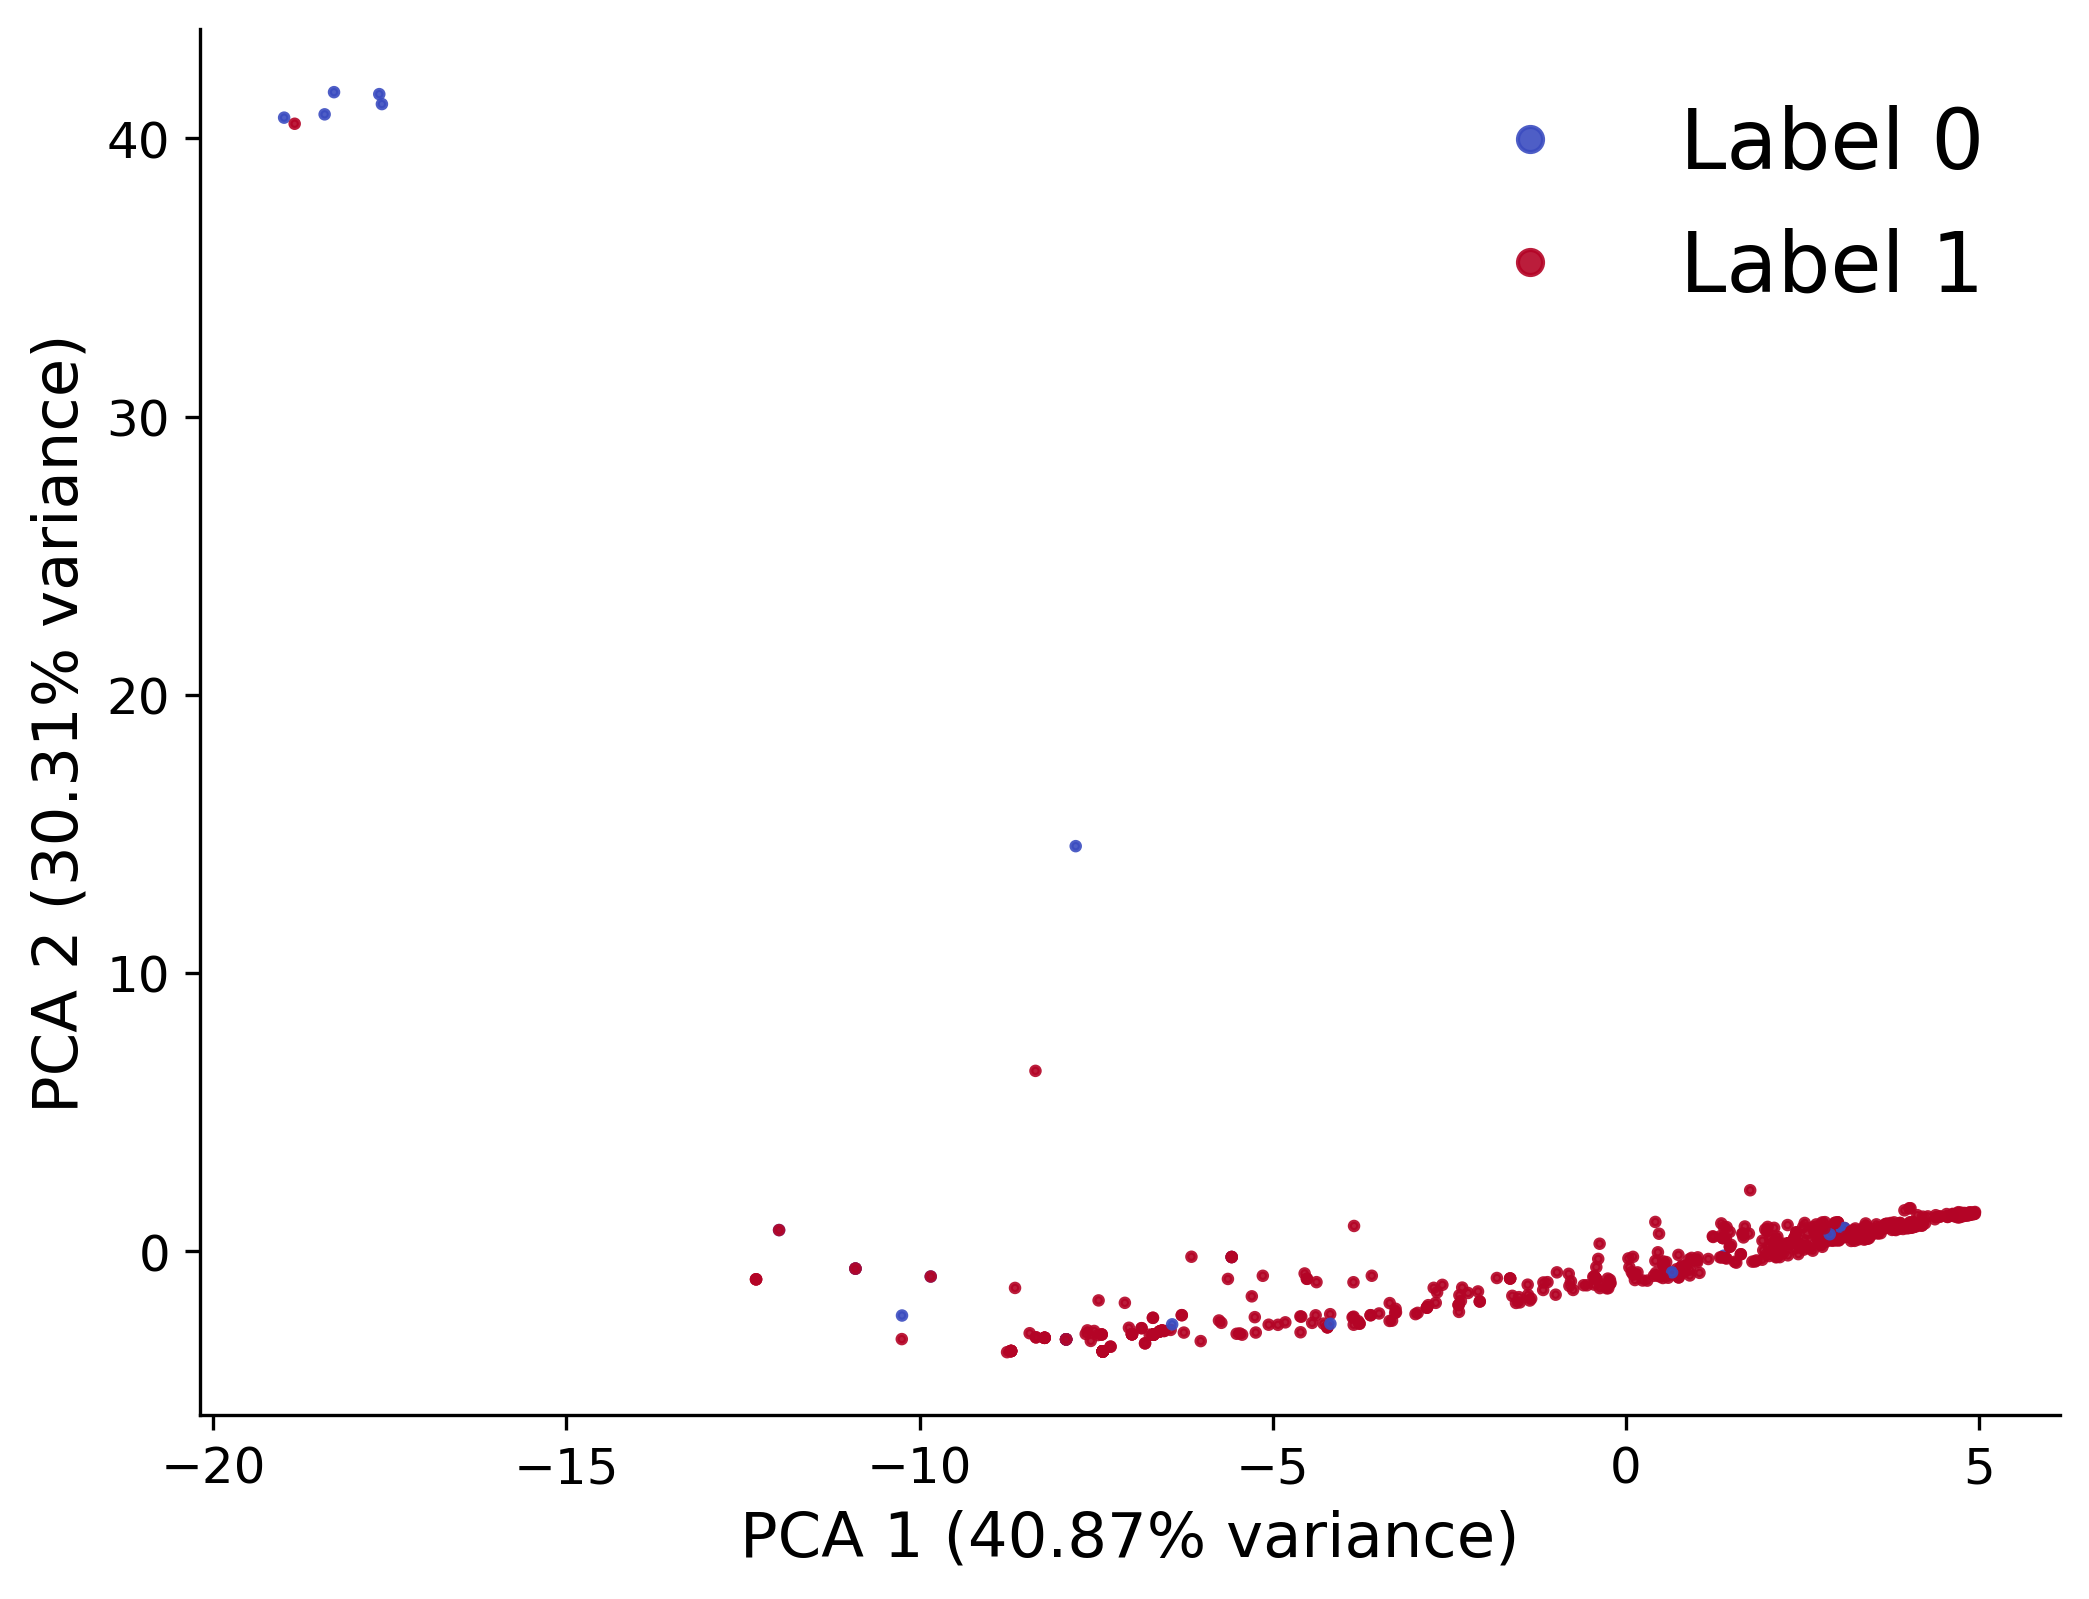

In [93]:
# 使用 PCA 对嵌入进行降维，同时获取主成分的解释方差百分比
def apply_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    explained_variance = pca.explained_variance_ratio_  # 获取每个主成分的解释方差
    return pca_result, explained_variance


# 可视化函数，同时显示解释方差百分比
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 为 labels 只有 0 和 1 两个值指定两个颜色
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=4)

    plt.xlabel(f'PCA 1 ({explained_variance[0]*100:.2f}% variance)', fontsize=15)
    plt.ylabel(f'PCA 2 ({explained_variance[1]*100:.2f}% variance)', fontsize=15)

    # 添加图例，手动指定标签
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=20,frameon=False)
    
    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    plt.show()



# 使用 PCA 降维，并获取解释方差
pca_result, explained_variance = apply_pca(smiles_embeddings, n_components=2)

# 绘制 PCA 图，并显示每个主成分的解释方差百分比
plot_pca_with_variance(pca_result, labels, explained_variance)

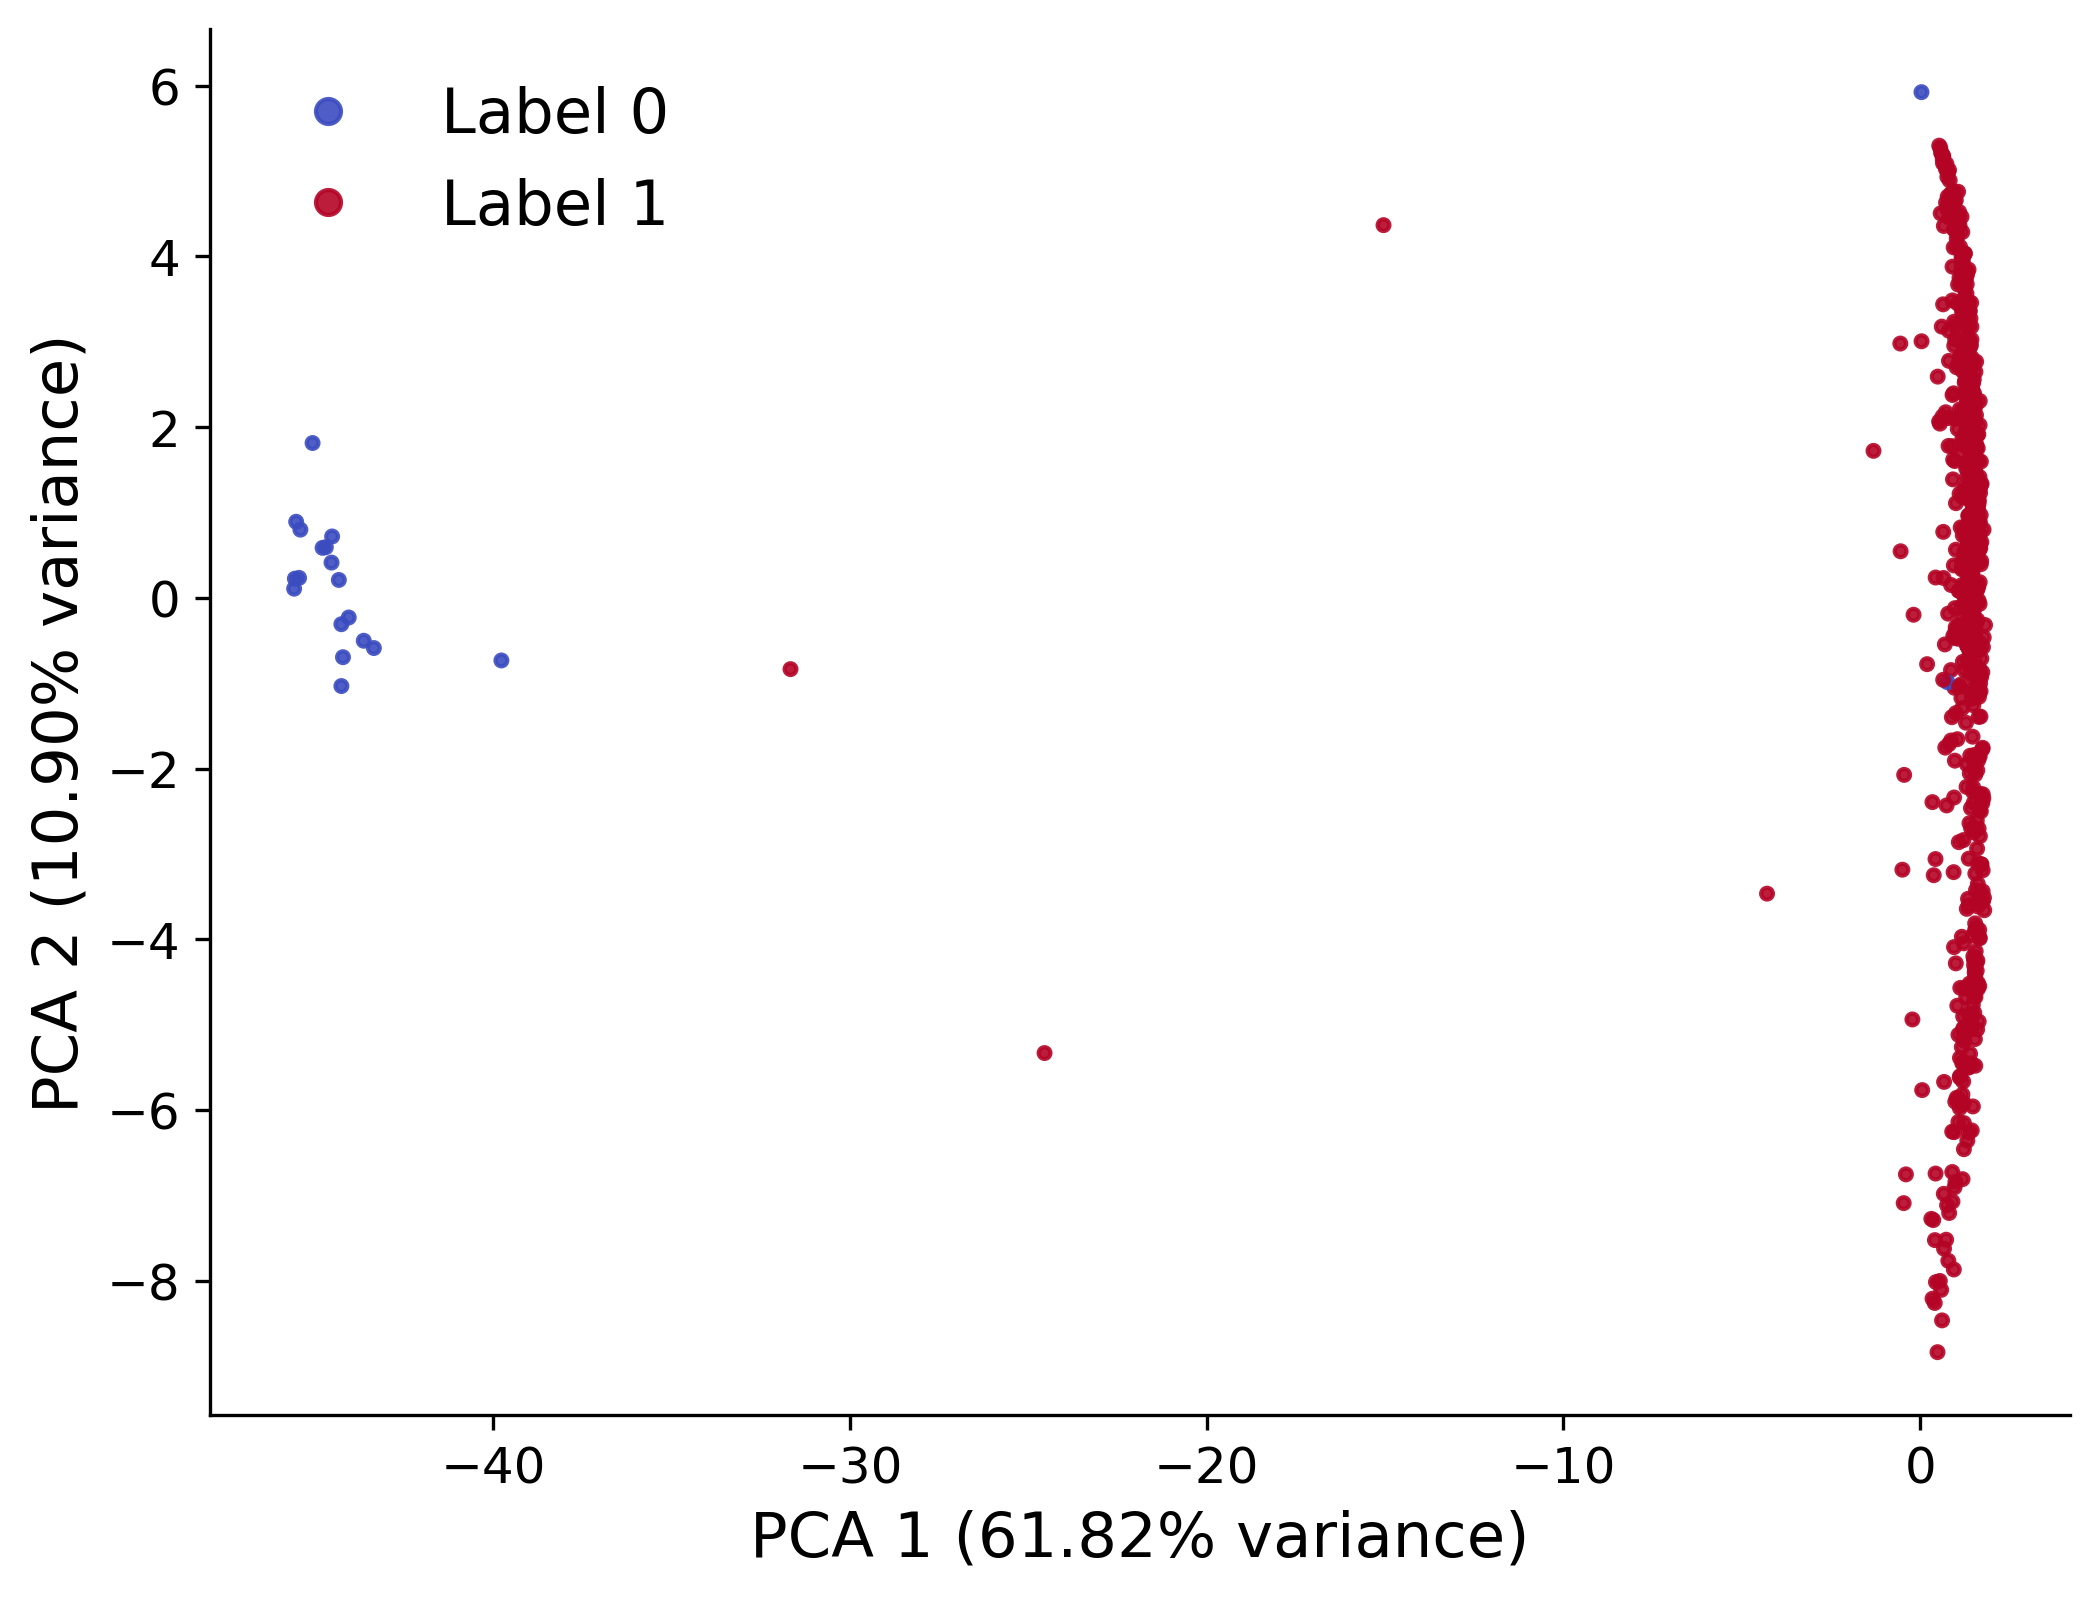

In [22]:
# 可视化函数，同时显示解释方差百分比
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 为 labels 只有 0 和 1 两个值指定两个颜色
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=8)

    plt.xlabel(f'PCA 1 ({explained_variance[0]*100:.2f}% variance)', fontsize=15)
    plt.ylabel(f'PCA 2 ({explained_variance[1]*100:.2f}% variance)', fontsize=15)

    # 添加图例，手动指定标签
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=15,frameon=False)
    
    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    plt.show()


# 绘制 PCA 图，并显示每个主成分的解释方差百分比
plot_pca_with_variance(pca_result, labels, explained_variance)

In [23]:
# 可视化函数，同时显示解释方差百分比
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 为 labels 只有 0 和 1 两个值指定两个颜色
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=4)

    plt.xlabel(f'PCA 1 ({explained_variance[0]*100:.2f}% variance)', fontsize=15)
    plt.ylabel(f'PCA 2 ({explained_variance[1]*100:.2f}% variance)', fontsize=15)

    # 添加图例，手动指定标签
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=15,frameon=False)
    
    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    plt.show()

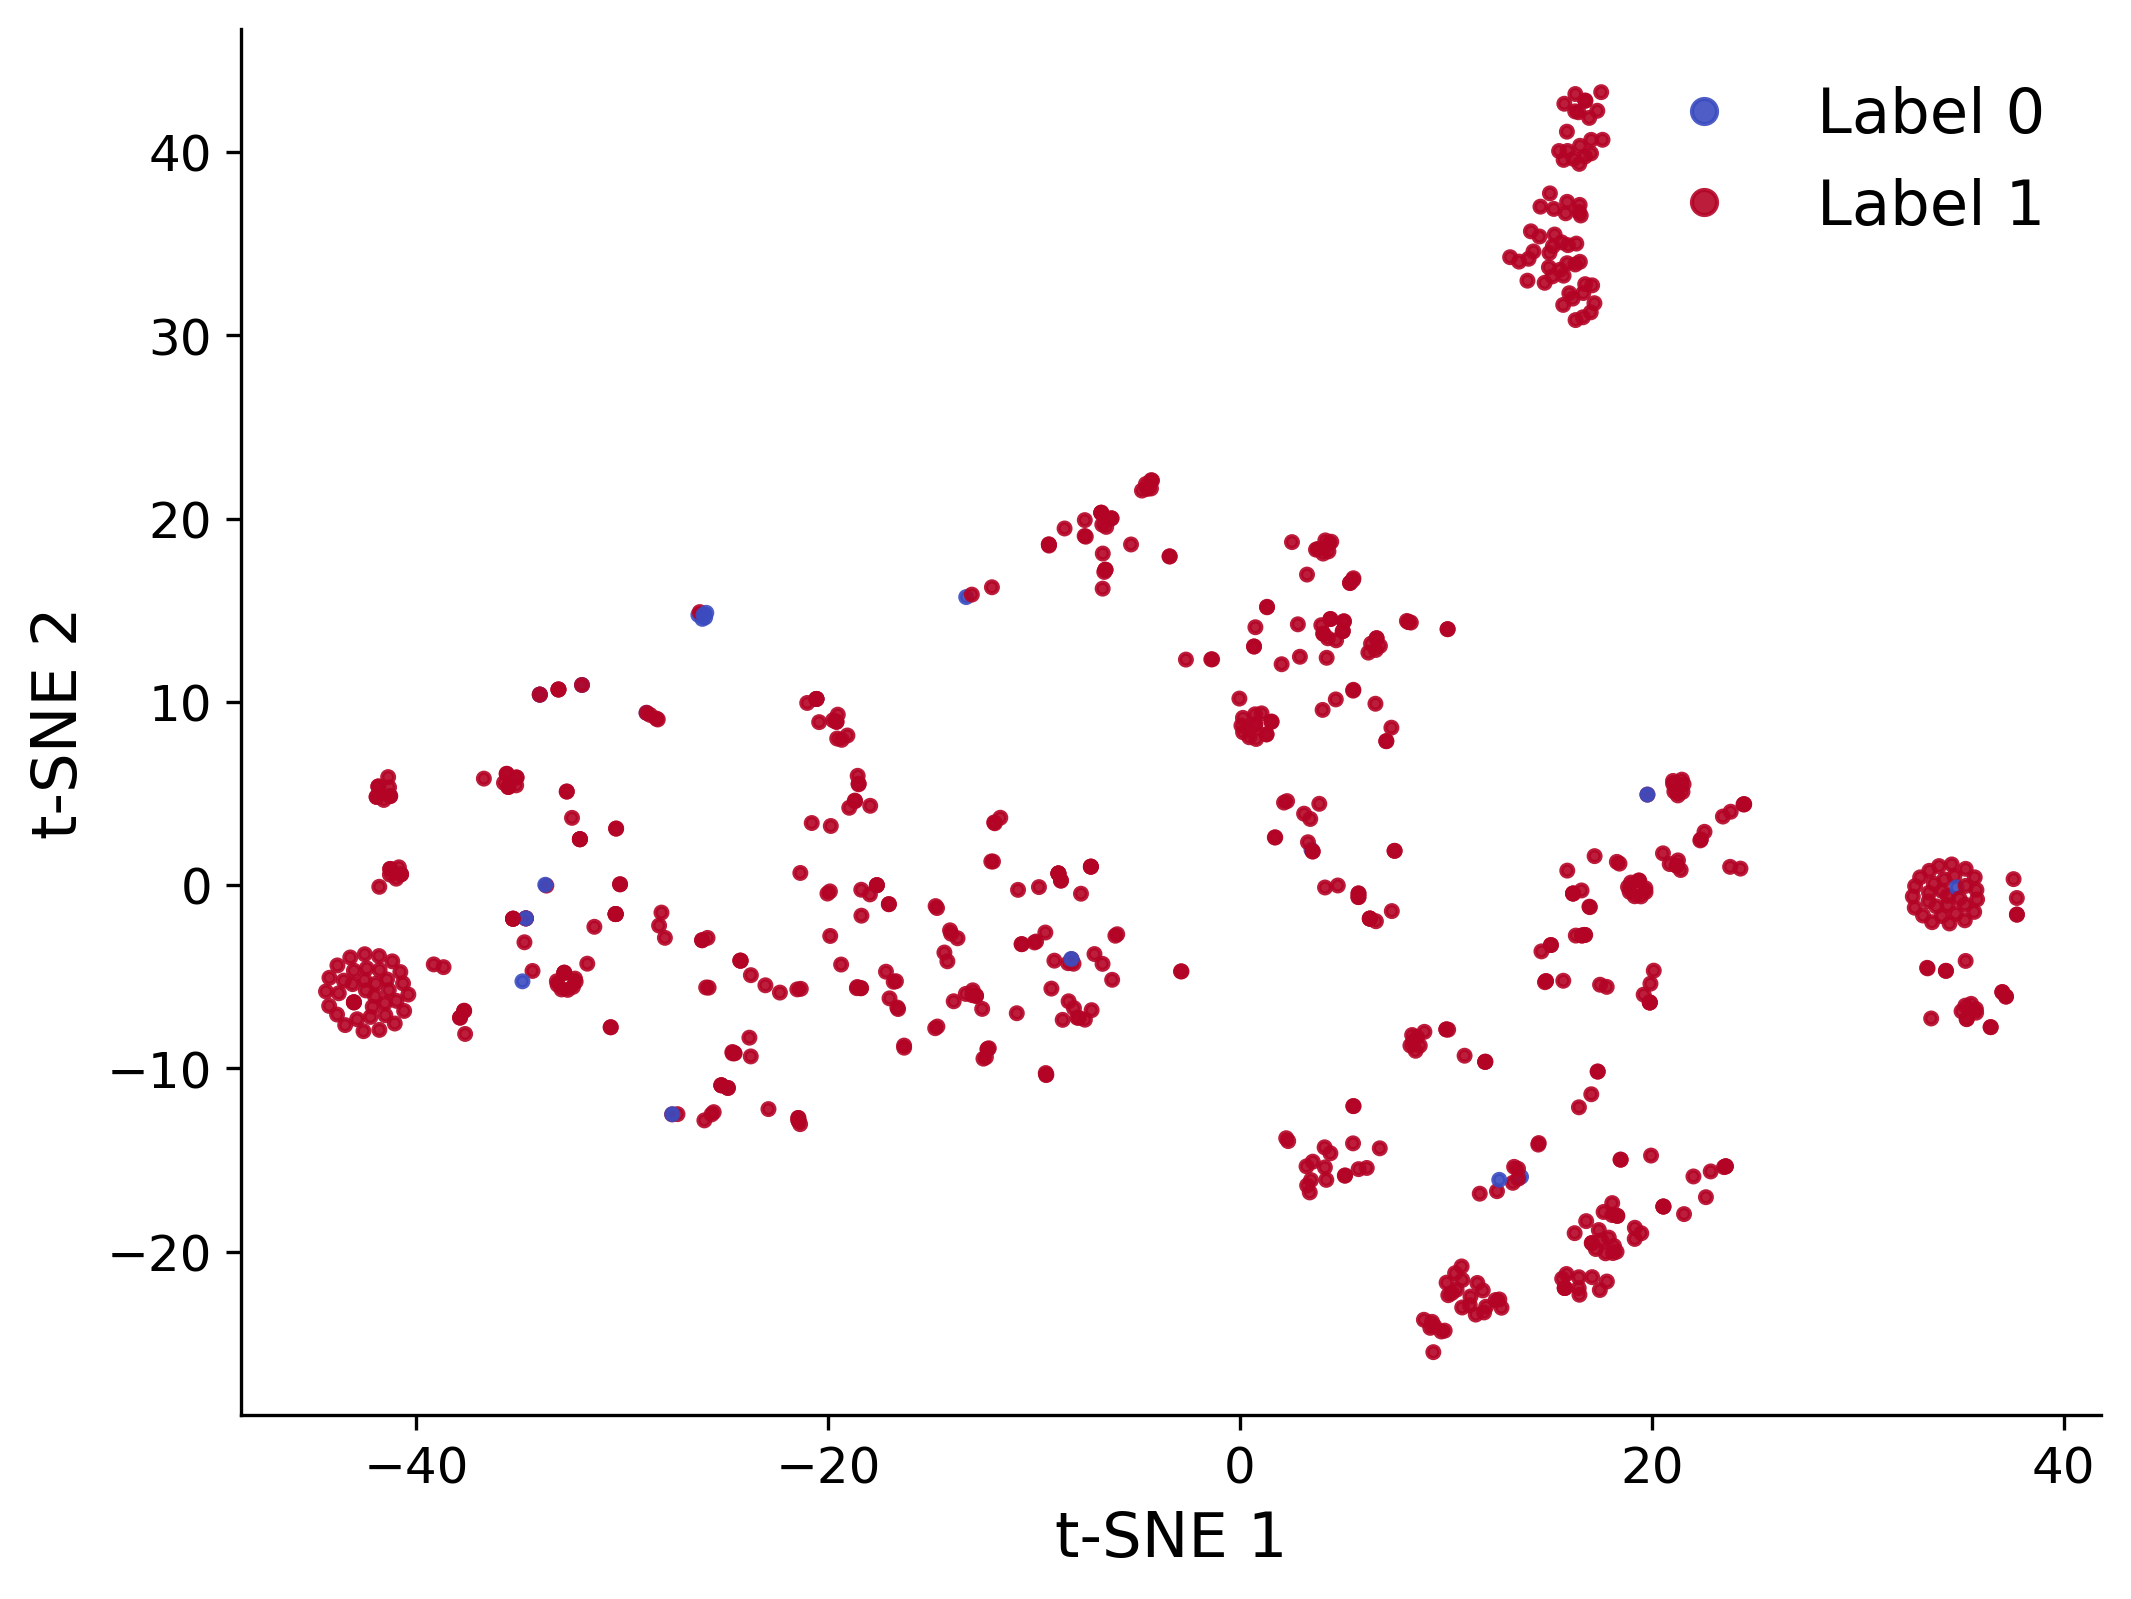

In [94]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import font_manager



# 使用 t-SNE 对嵌入进行降维，同时获取每个主成分的解释方差百分比
def apply_tsne(embeddings, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=42)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result

def plot_tsne_with_variance(tsne_result, labels):
    plt.figure(figsize=(8, 6),dpi=300)
    
    # 绘制散点图，使用 'coolwarm' colormap，labels 作为着色依据
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=8)

    # 添加 colorbar
    #cbar = plt.colorbar(scatter)
    #cbar.set_label('lables', fontsize=15, fontproperties=prop)  # 设置 colorbar 的字体大小
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=15,frameon=False)
    
    # 设置坐标轴标签
    plt.xlabel('t-SNE 1', fontsize=15)
    plt.ylabel('t-SNE 2', fontsize=15)

    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 显示左侧框线
    ax.spines['right'].set_visible(False)  # 显示底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    # 显示图形
    plt.show()




# 使用 t-SNE 降维
tsne_result = apply_tsne(smiles_embeddings, n_components=2)

# 绘制 t-SNE 图
plot_tsne_with_variance(tsne_result, labels)


In [21]:
np.save('./CLS_smiles_embeddings.npy', smiles_embeddings)

In [95]:
smiles_embeddings.shape

(708, 768)

In [96]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem

from sklearn.metrics import roc_curve




y = labels
X = smiles_embeddings


# 训练和评估函数
def train_evaluate_model_with_optuna(model_name, model_class, param_func, X_train, y_train,X_test,y_test):
    def objective(trial):
        params = param_func(trial)
        if model_class == SVC:
            params['probability'] = True

        model = model_class(**params)
        pr_auc_scores = []

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall, precision)
        

        return pr_auc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print(f'Best parameters for {model_name}: {study.best_params}')
    best_params = study.best_params


    # 使用最优超参数训练最优模型
    best_model = model_class(**best_params)
    best_model.fit(X_train, y_train)

    model_save_path="./best_xgb.joblib"
    joblib.dump(best_model, model_save_path)  # 保存模型



def xgb_param_func(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }



In [97]:
import warnings
from rdkit import RDLogger

# 屏蔽 RDKit 警告
RDLogger.DisableLog('rdApp.*')

# 或屏蔽所有 Python 警告
warnings.filterwarnings("ignore")
# 屏蔽 LightGBM 警告
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

In [99]:
print("Training XGBoost...")
train_evaluate_model_with_optuna("XGBoost", XGBClassifier, xgb_param_func, X_train, y_train, X_test,y_test)

[I 2025-03-03 13:43:36,964] A new study created in memory with name: no-name-0f08999c-65ba-4c60-b6d2-916a5fe9c4d9


Training XGBoost...


[I 2025-03-03 13:43:43,453] Trial 0 finished with value: 1.0000000000000002 and parameters: {'n_estimators': 886, 'max_depth': 45, 'learning_rate': 0.024350091289771454}. Best is trial 0 with value: 1.0000000000000002.
[I 2025-03-03 13:43:47,276] Trial 1 finished with value: 0.9999476789079134 and parameters: {'n_estimators': 712, 'max_depth': 45, 'learning_rate': 0.6592988482603404}. Best is trial 0 with value: 1.0000000000000002.
[I 2025-03-03 13:43:51,495] Trial 2 finished with value: 1.0000000000000002 and parameters: {'n_estimators': 580, 'max_depth': 19, 'learning_rate': 0.024567454541429837}. Best is trial 0 with value: 1.0000000000000002.
[I 2025-03-03 13:43:54,101] Trial 3 finished with value: 0.9999476789079135 and parameters: {'n_estimators': 414, 'max_depth': 4, 'learning_rate': 0.019522707918419507}. Best is trial 0 with value: 1.0000000000000002.
[I 2025-03-03 13:43:56,843] Trial 4 finished with value: 0.9999476789079134 and parameters: {'n_estimators': 524, 'max_depth': 

Best parameters for XGBoost: {'n_estimators': 886, 'max_depth': 45, 'learning_rate': 0.024350091289771454}


In [30]:
# 直接使用最优参数进行五折交叉验证
def train_evaluate_with_best_params(model_name, model_class, best_params, X, y):
    # 创建模型并设置最优参数
    model = model_class(**best_params)

    # 五折交叉验证
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 存储各个折的评价指标
    metrics_train = {'PR-AUC': [], 'AU-ROC': [], 'ACC': [], 'PREC': [], 'REC': [], 'F1': []}
    metrics_test = {'PR-AUC': [], 'AU-ROC': [], 'ACC': [], 'PREC': [], 'REC': [], 'F1': []}
    
    # 使用 tqdm 包裹五折交叉验证的每一折
    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=5, desc=f"Training {model_name}")):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        
        # 训练集指标
        y_prob_train = model.predict_proba(X_train)[:, 1]
        precision_train, recall_train, _ = precision_recall_curve(y_train, y_prob_train)
        pr_auc_train = auc(recall_train, precision_train)
        metrics_train['PR-AUC'].append(pr_auc_train)

        fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
        auc_train = auc(fpr_train, tpr_train)
        metrics_train['AU-ROC'].append(auc_train)

        accuracy_train = accuracy_score(y_train, (y_prob_train > 0.5).astype(int))
        metrics_train['ACC'].append(accuracy_train)

        precision_train_val = precision_score(y_train, (y_prob_train > 0.5).astype(int))
        metrics_train['PREC'].append(precision_train_val)

        recall_train_val = recall_score(y_train, (y_prob_train > 0.5).astype(int))
        metrics_train['REC'].append(recall_train_val)

        f1_train_val = f1_score(y_train, (y_prob_train > 0.5).astype(int))
        metrics_train['F1'].append(f1_train_val)

        # 测试集指标
        y_prob_test = model.predict_proba(X_val)[:, 1]
        precision_test, recall_test, _ = precision_recall_curve(y_val, y_prob_test)
        pr_auc_test = auc(recall_test, precision_test)
        metrics_test['PR-AUC'].append(pr_auc_test)

        fpr_test, tpr_test, _ = roc_curve(y_val, y_prob_test)
        auc_test = auc(fpr_test, tpr_test)
        metrics_test['AU-ROC'].append(auc_test)

        accuracy_test = accuracy_score(y_val, (y_prob_test > 0.5).astype(int))
        metrics_test['ACC'].append(accuracy_test)

        precision_test_val = precision_score(y_val, (y_prob_test > 0.5).astype(int))
        metrics_test['PREC'].append(precision_test_val)

        recall_test_val = recall_score(y_val, (y_prob_test > 0.5).astype(int))
        metrics_test['REC'].append(recall_test_val)

        f1_test_val = f1_score(y_val, (y_prob_test > 0.5).astype(int))
        metrics_test['F1'].append(f1_test_val)

        # 输出当前折的训练集和测试集评价指标
        print(f"Fold {fold + 1} - Train metrics:")
        for metric, values in metrics_train.items():
            print(f"  {metric}: {values[-1]:.4f}")
        
        print(f"Fold {fold + 1} - Test metrics:")
        for metric, values in metrics_test.items():
            print(f"  {metric}: {values[-1]:.4f}")
        print()

        # 将训练集和测试集的结果合并成一个 DataFrame
    results = {
        'Metric': ['PR-AUC', 'AU-ROC', 'F1', 'REC', 'PREC', 'ACC'],
        'Train': [
            np.mean(metrics_train['PR-AUC']),
            np.mean(metrics_train['AU-ROC']),
            np.mean(metrics_train['F1']),
            np.mean(metrics_train['REC']),
            np.mean(metrics_train['PREC']),
            np.mean(metrics_train['ACC'])
        ],
        'Test': [
            np.mean(metrics_test['PR-AUC']),
            np.mean(metrics_test['AU-ROC']),
            np.mean(metrics_test['F1']),
            np.mean(metrics_test['REC']),
            np.mean(metrics_test['PREC']),
            np.mean(metrics_test['ACC'])
        ]
    }
    
    df_results = pd.DataFrame(results)

    # 保存结果到CSV文件
    df_results.to_csv(f'{model_name}_evaluation_metrics.csv', index=False)
    print(f"Metrics saved to {model_name}_evaluation_metrics.csv")




    
    # 输出每个评价指标的训练集和测试集平均值
    print(f'Average Train PR AUC: {np.mean(metrics_train["PR-AUC"]):.4f}')
    print(f'Average Test PR AUC: {np.mean(metrics_test["PR-AUC"]):.4f}')

    print(f'Average Train AU-ROC: {np.mean(metrics_train["AU-ROC"]):.4f}')
    print(f'Average Test AU-ROC: {np.mean(metrics_test["AU-ROC"]):.4f}')

    print(f'Average Train Accuracy: {np.mean(metrics_train["ACC"]):.4f}')
    print(f'Average Test Accuracy: {np.mean(metrics_test["ACC"]):.4f}')

    print(f'Average Train Precision: {np.mean(metrics_train["PREC"]):.4f}')
    print(f'Average Test Precision: {np.mean(metrics_test["PREC"]):.4f}')

    print(f'Average Train Recall: {np.mean(metrics_train["REC"]):.4f}')
    print(f'Average Test Recall: {np.mean(metrics_test["REC"]):.4f}')

    print(f'Average Train F1: {np.mean(metrics_train["F1"]):.4f}')
    print(f'Average Test F1: {np.mean(metrics_test["F1"]):.4f}')


In [33]:
import numpy as np
y = np.array(y)  # 将 y 转换为 NumPy 数组
print(y.shape)    # 现在你可以使用 .shape 属性


(708,)


In [34]:
import torch
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from xgboost import XGBClassifier
import joblib
from tqdm import tqdm
from rdkit.Chem import Descriptors, AllChem

from sklearn.metrics import roc_curve


In [35]:
{'n_estimators': 177, 'max_depth': 40, 'learning_rate': 0.9188658231107774}


{'n_estimators': 177, 'max_depth': 40, 'learning_rate': 0.9188658231107774}

In [36]:
# 最优参数
best_params_xgb = {'n_estimators': 177, 'max_depth': 40, 'learning_rate': 0.9188658231107774,'eval_metric': 'error' }

# 训练并评估 XGBoost 模型
train_evaluate_with_best_params("XGBoost", XGBClassifier, best_params_xgb, X, y)

Training XGBoost:  20%|██        | 1/5 [00:00<00:01,  2.09it/s]

Fold 1 - Train metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 0.9982
  PREC: 0.9982
  REC: 1.0000
  F1: 0.9991
Fold 1 - Test metrics:
  PR-AUC: 0.9998
  AU-ROC: 0.9937
  ACC: 0.9859
  PREC: 0.9928
  REC: 0.9928
  F1: 0.9928



Training XGBoost:  40%|████      | 2/5 [00:00<00:01,  2.21it/s]

Fold 2 - Train metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 1.0000
  PREC: 1.0000
  REC: 1.0000
  F1: 1.0000
Fold 2 - Test metrics:
  PR-AUC: 0.9914
  AU-ROC: 0.8125
  ACC: 0.9930
  PREC: 0.9928
  REC: 1.0000
  F1: 0.9964



Training XGBoost:  60%|██████    | 3/5 [00:01<00:00,  2.24it/s]

Fold 3 - Train metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 1.0000
  PREC: 1.0000
  REC: 1.0000
  F1: 1.0000
Fold 3 - Test metrics:
  PR-AUC: 0.9911
  AU-ROC: 0.8107
  ACC: 0.9789
  PREC: 0.9927
  REC: 0.9855
  F1: 0.9891



Training XGBoost:  80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

Fold 4 - Train metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 0.9982
  PREC: 0.9982
  REC: 1.0000
  F1: 0.9991
Fold 4 - Test metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 1.0000
  PREC: 1.0000
  REC: 1.0000
  F1: 1.0000



Training XGBoost: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

Fold 5 - Train metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 0.9982
  PREC: 0.9982
  REC: 1.0000
  F1: 0.9991
Fold 5 - Test metrics:
  PR-AUC: 1.0000
  AU-ROC: 1.0000
  ACC: 1.0000
  PREC: 1.0000
  REC: 1.0000
  F1: 1.0000

Metrics saved to XGBoost_evaluation_metrics.csv
Average Train PR AUC: 1.0000
Average Test PR AUC: 0.9965
Average Train AU-ROC: 1.0000
Average Test AU-ROC: 0.9234
Average Train Accuracy: 0.9989
Average Test Accuracy: 0.9915
Average Train Precision: 0.9989
Average Test Precision: 0.9957
Average Train Recall: 1.0000
Average Test Recall: 0.9957
Average Train F1: 0.9995
Average Test F1: 0.9956


In [ ]:
#val_r2 = r2_score(np.expm1(all_labels), np.expm1(all_preds))  # 还原 log1p 的值